In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'medium',
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'medium',
#          'ytick.labelsize':'medium'}
# pylab.rcParams.update(params)

#line thickness
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 5


def score_transform_new(iso, pt):
    
    PFTAU_NN_OFFSET = 0.36865313
    PFTAU_NN_SLOPE = 0.00137913
    PFTAU_NN_OVERALL_SCALE = 1./3.

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 200.0
    
    return iso*PFTAU_NN_OVERALL_SCALE*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

#####----------------------------------------------------------------

model_name = '../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
        
# def score_transform(iso, pt):
    
#     PFTAU_NN_OFFSET = 0.1
#     PFTAU_NN_SLOPE = 0.2
#     PFTAU_NN_OVERALL_SCALE = 1. / 20.1

#     PFTAU_NN_LOOSE_CUT = 0.05
#     PFTAU_NN_TIGHT_CUT = 0.25

#     PFTAU_NN_PT_CUTOFF = 100.0
    
#     return iso*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))*PFTAU_NN_OVERALL_SCALE

2023-02-07 12:08:19.392018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 12:08:19.546065: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-07 12:08:20.357828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2023-02-07 12:08:20.357957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

# Plot efficiency w.r.t tau's pT (testing data)

In [34]:
def plot_pt_eff(ModelName, DataPath, TreeName='ntuplePupSingle', cut_point = 0.05, test_indx=400000):
    
    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model = load_model(ModelName)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>1.) # " abs(gendr1) < 0.4 && pt > 1."

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]
    reco_tau_pt_select = reco_tau_pt[selection_num]
    
    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model.predict(np.nan_to_num(X_sig))
    
    nn_cut = y_sig.flatten() > cut_point
    
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Old nn
    old_tau_select = np.asarray(sig[TreeName]['tree']['passLoose'].array()[test_indx:][selection_num])
    tau_pt_old_nn = truth_tau_pt_select[old_tau_select == 1]

    #Fill two plots and divide the two.
    pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)
    hist_selected_old_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_tau.fill(tau_pt_nn)
    hist_selected_old_tau.fill(tau_pt_old_nn)
    
    
    fig = plt.figure(figsize=(10, 12))
    main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > 0.05)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (Old NN)",
        rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    
    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = eff_new_nn_artists.bar.datavalues

    eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_err = eff_old_nn_artists.bar.datavalues

    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN (> 0.05)')
    plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN (PassLoose)')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"Efficiency")
    plt.legend(loc = 'center right')
    plt.show()

In [32]:
def plot_pt_eff_puppi(ModelName, DataPath, TreeName='ntuplePupSingle', cut_point = 0.05, test_indx=400000):
    
    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model = load_model(ModelName)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>1.) # " abs(gendr1) < 0.4 && pt > 1."

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]
    reco_tau_pt_select = reco_tau_pt[selection_num]
    
    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model.predict(np.nan_to_num(X_sig))
    
    nn_cut = y_sig.flatten() > cut_point
    
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Old nn
    old_tau_select = np.asarray(sig[TreeName]['tree']['passLoose'].array()[test_indx:][selection_num])
    tau_pt_old_nn = truth_tau_pt_select[old_tau_select == 1]

    #Fill two plots and divide the two.
    pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)
    hist_selected_old_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)
    hist_selected_old_tau.fill(tau_pt_old_nn)
    
    
    fig = plt.figure(figsize=(10, 12))
    main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > 0.05)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (Old NN)",
        rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    
    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = eff_new_nn_artists.bar.datavalues

    eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_err = eff_old_nn_artists.bar.datavalues
    
    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err = eff_puppi_artists.bar.datavalues

    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN (> 0.05)')
    plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN (PassLoose)')
    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err, fmt='o', label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"Efficiency")
    plt.legend(loc = 'center right')
    plt.show()

1545/1545 [==============================] - 1s 702us/step


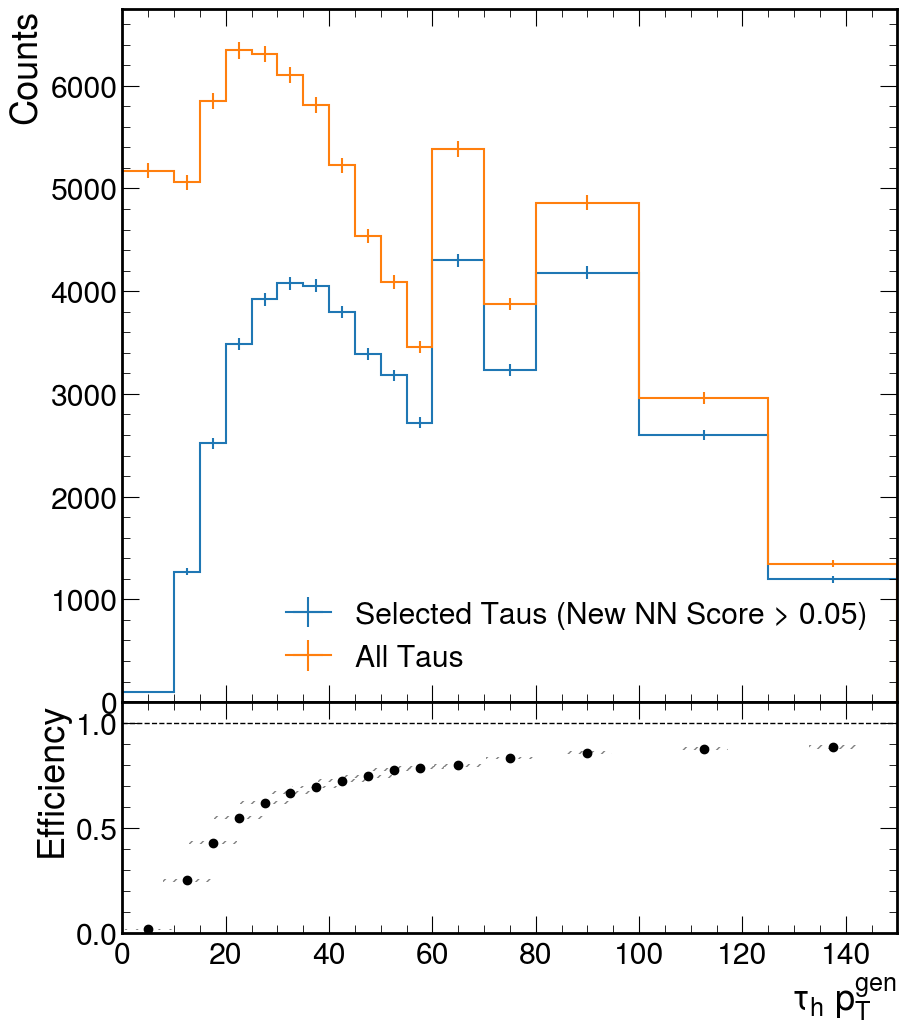

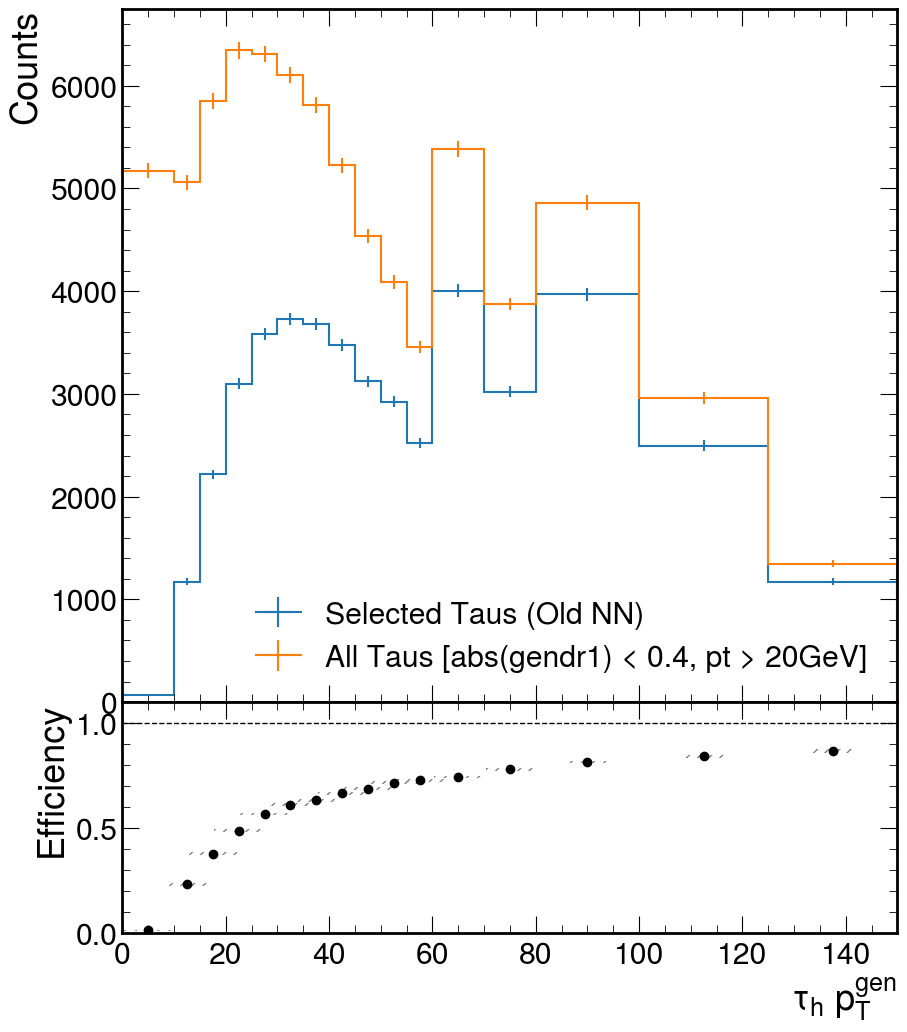

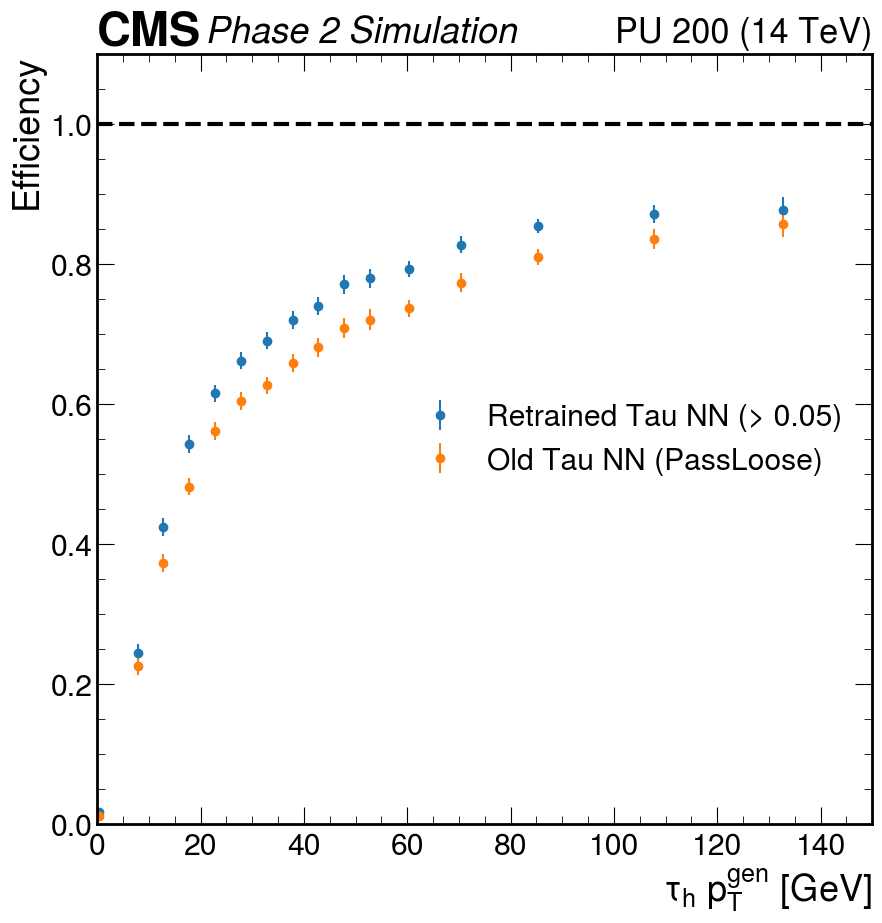

In [35]:
plot_pt_eff('../models/Feb_4_2023_JetMetTalk_v2_pTShape_TruthPtRatio.h5', "../ntuples/Jan_25_2023/test_sig_v11.root", cut_point = 0.05)

1545/1545 [==============================] - 1s 692us/step


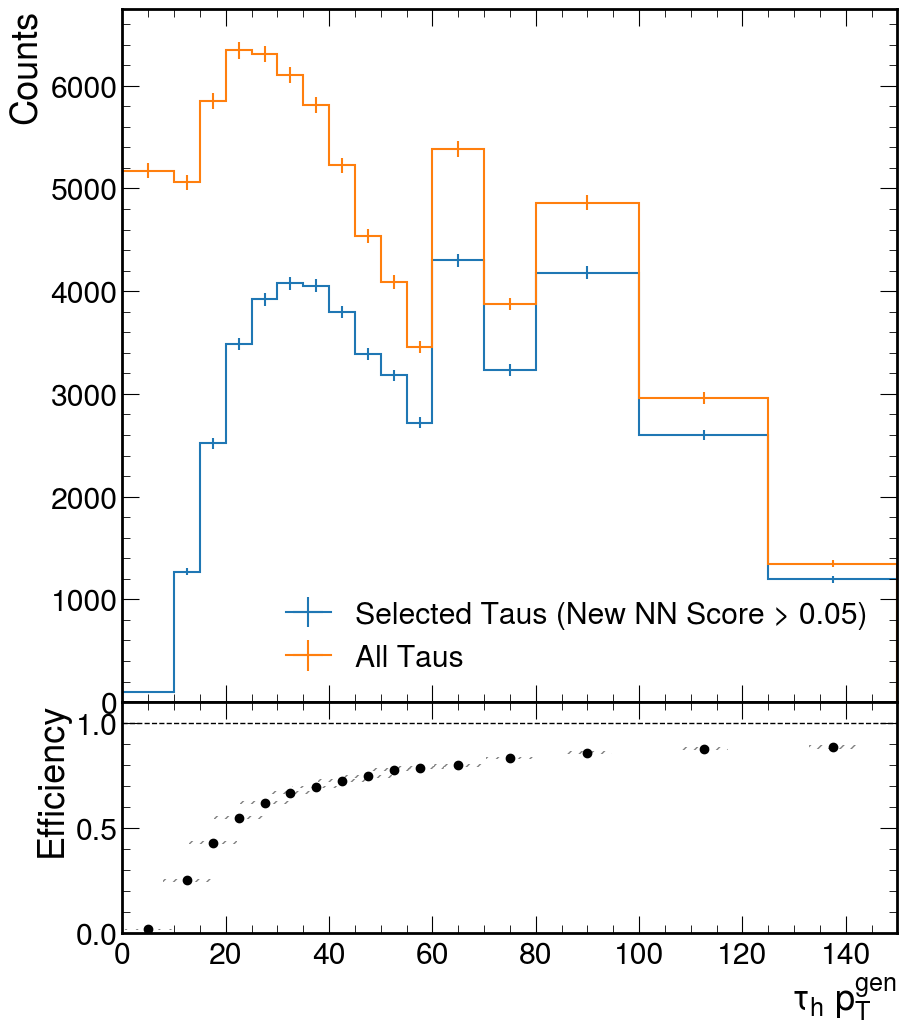

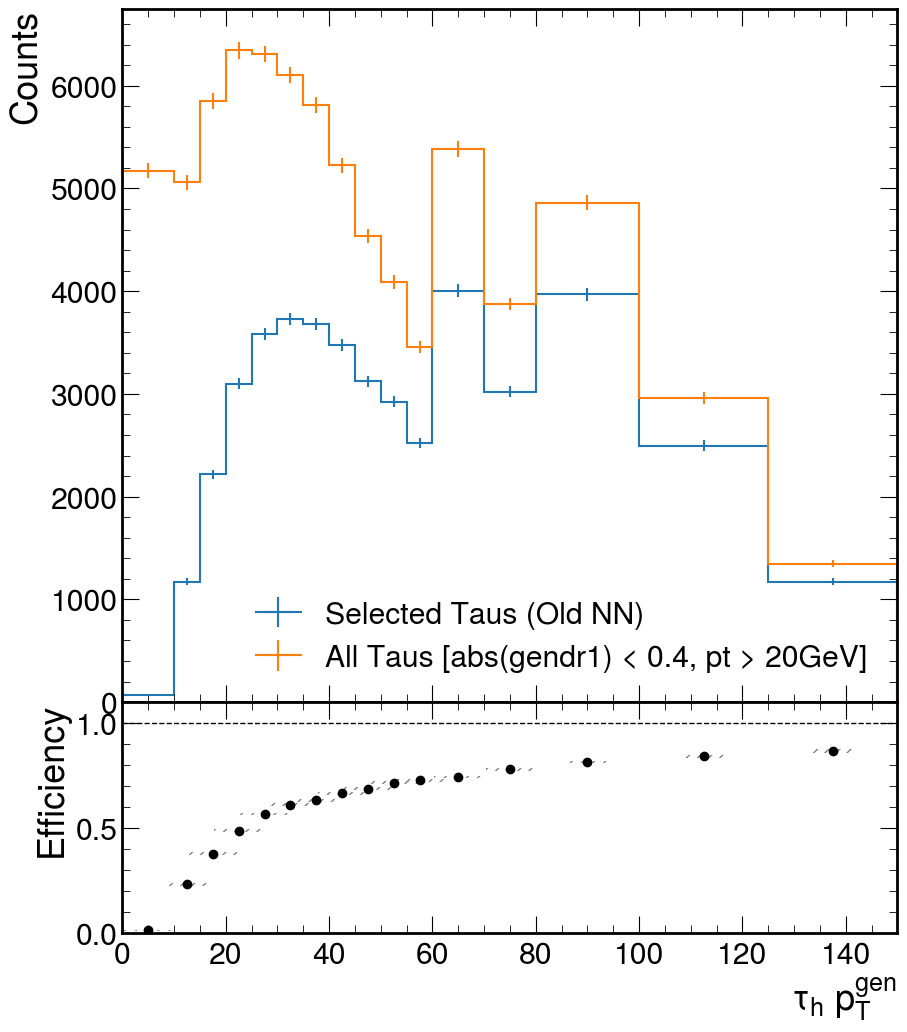

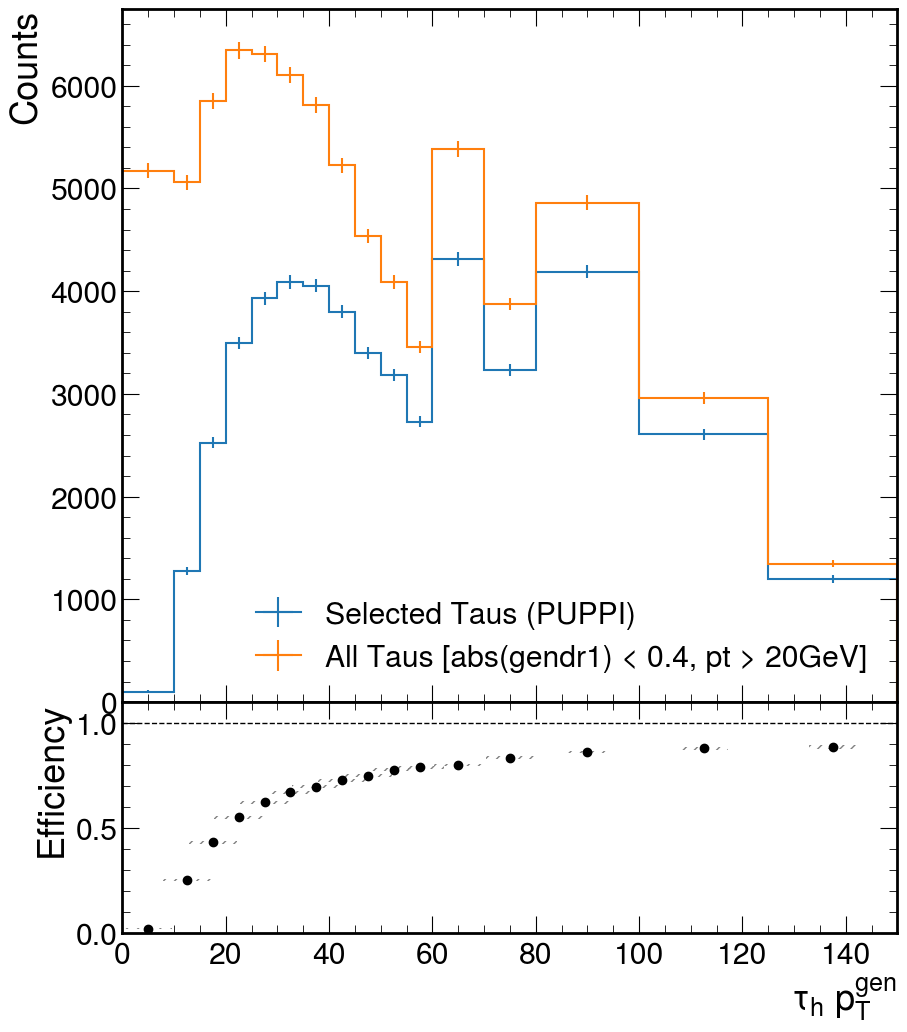

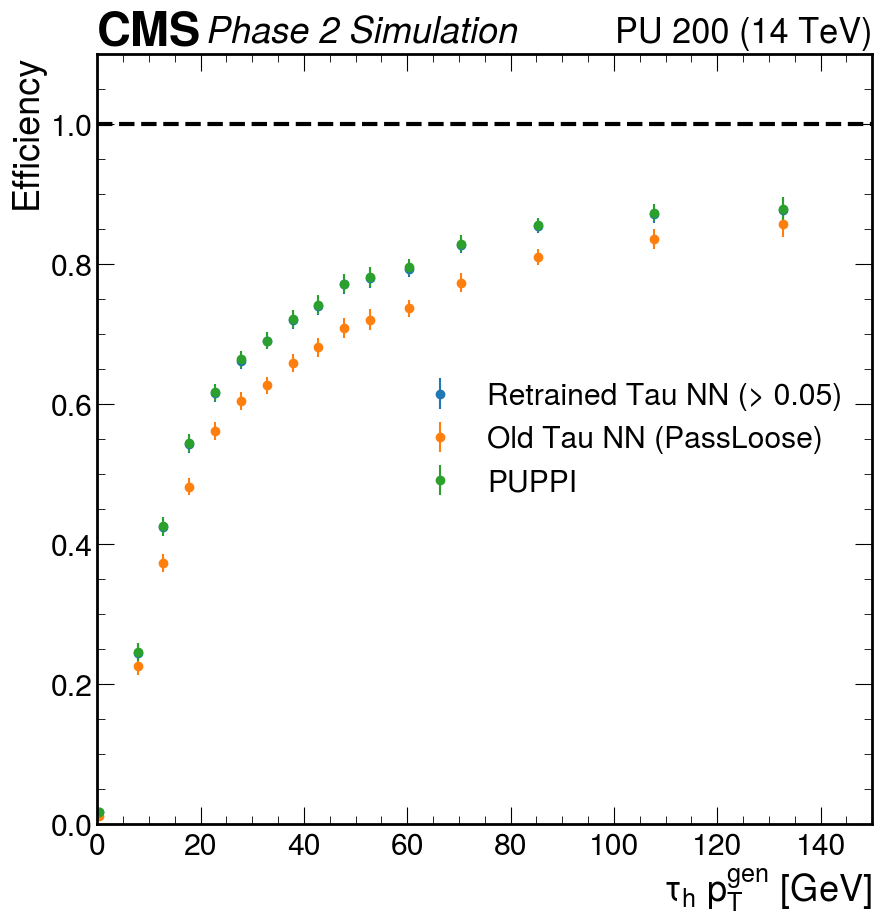

In [33]:
plot_pt_eff_puppi('../models/Feb_4_2023_JetMetTalk_v2_pTShape_TruthPtRatio.h5', "../ntuples/Jan_25_2023/test_sig_v11.root", cut_point = 0.05)

1905/1905 [==============================] - 1s 700us/step


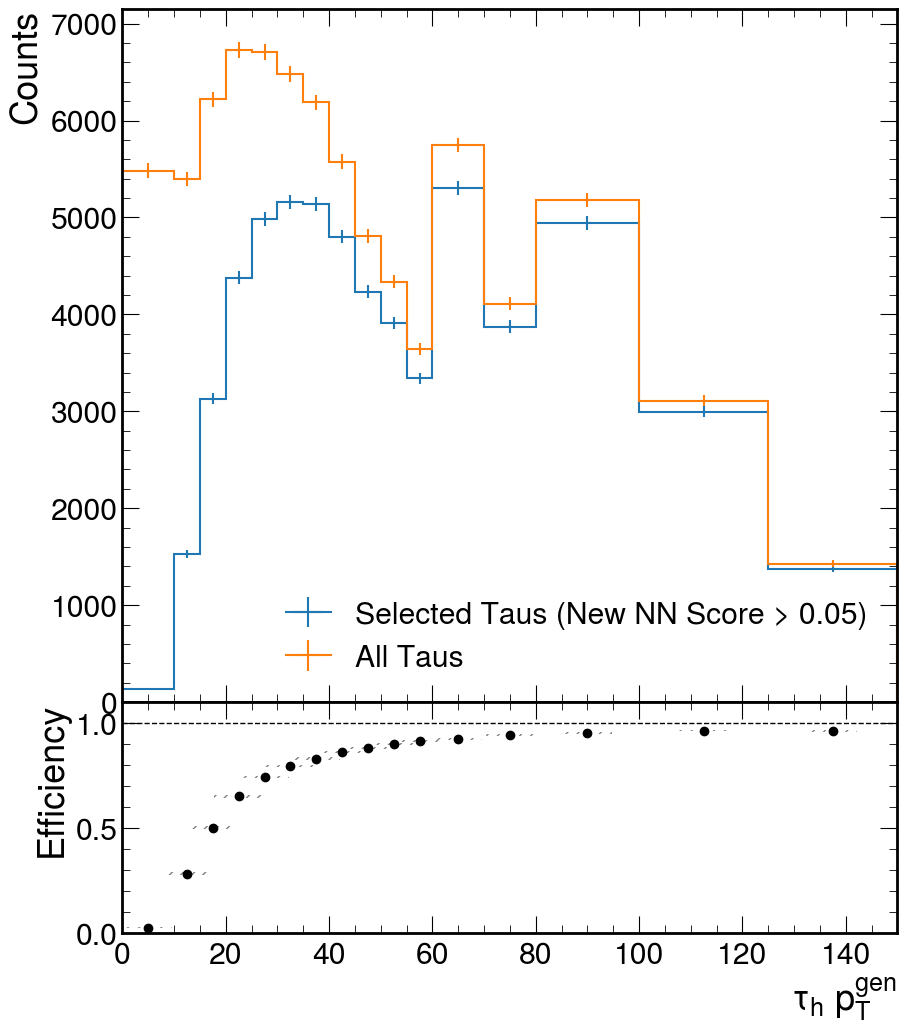

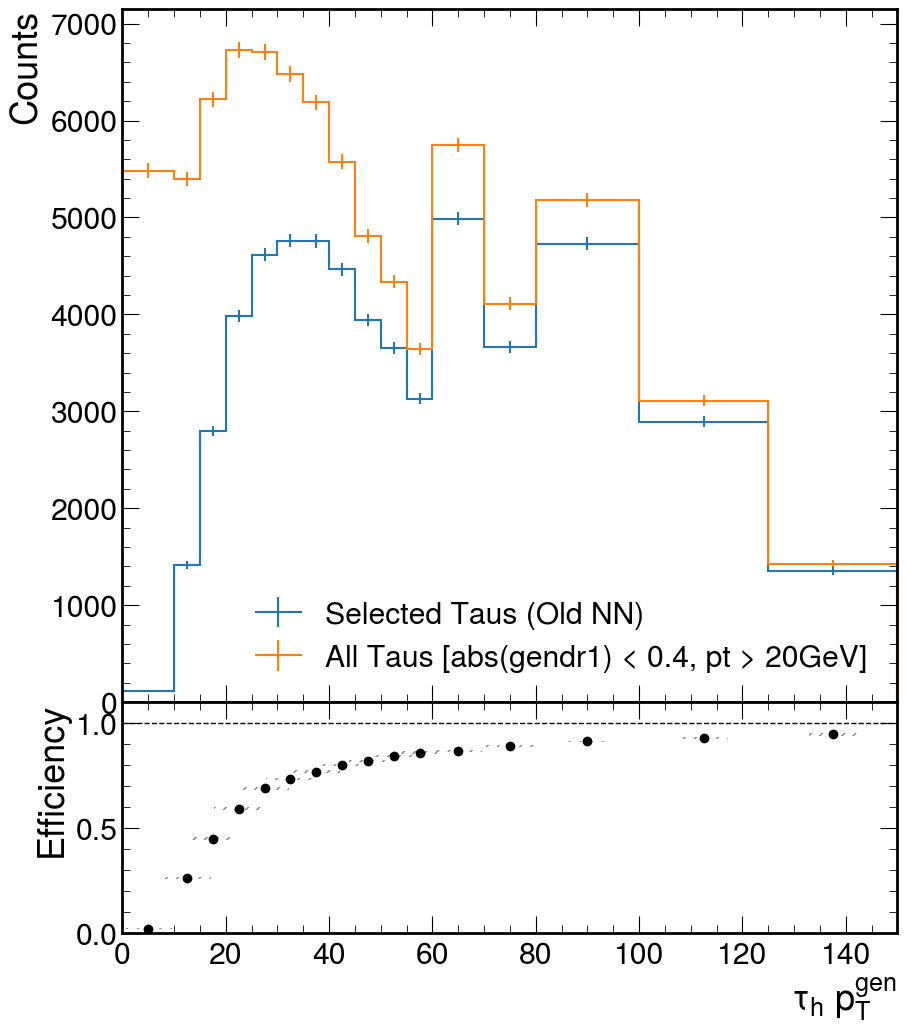

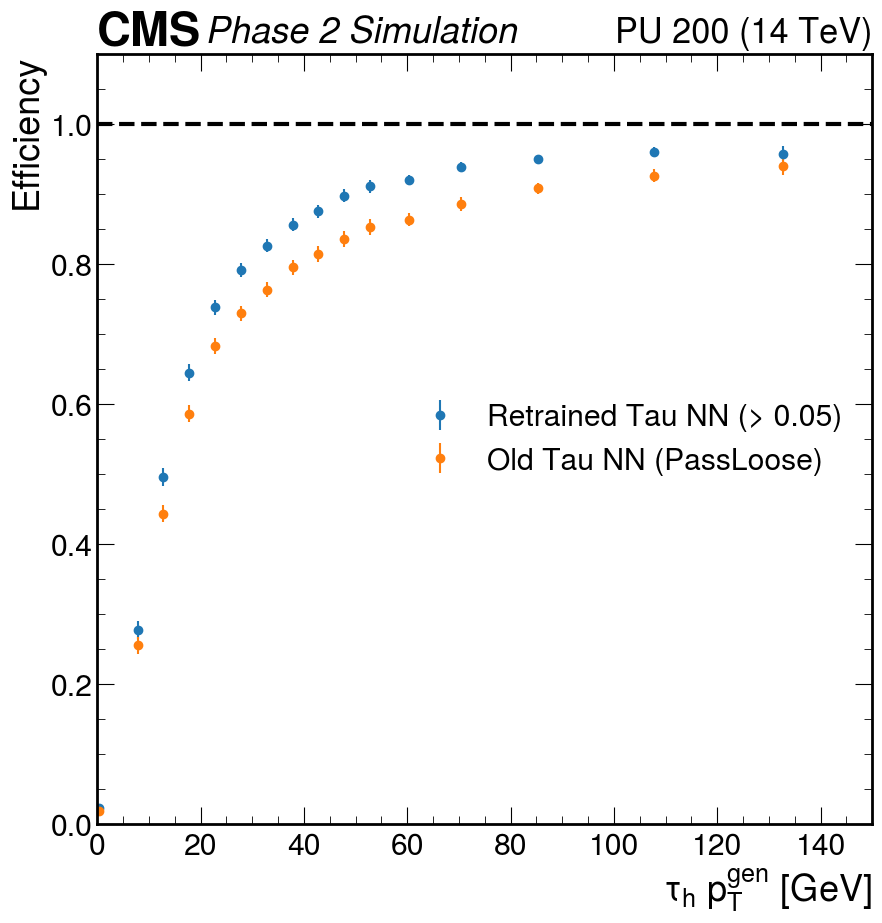

In [39]:
plot_pt_eff('../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5', "../ntuples/Jan_25_2023/test_sig_v12_emseed.root", cut_point = 0.05)

1905/1905 [==============================] - 1s 717us/step


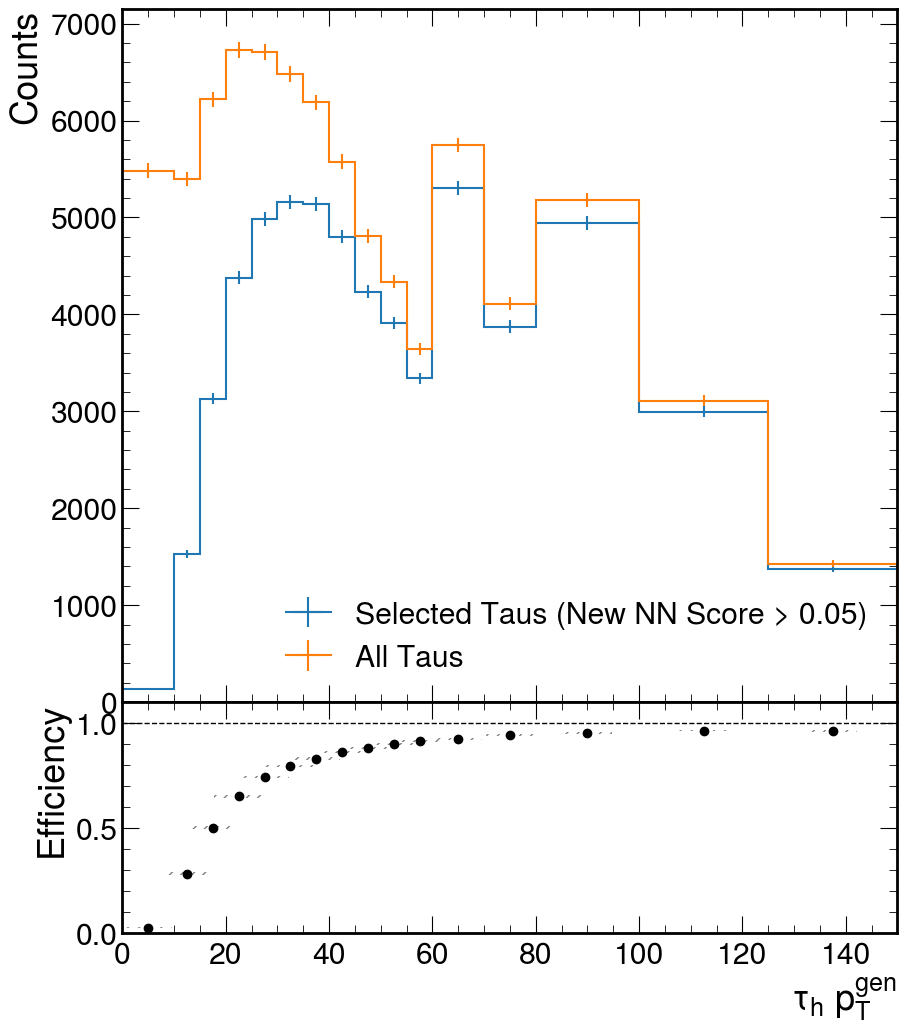

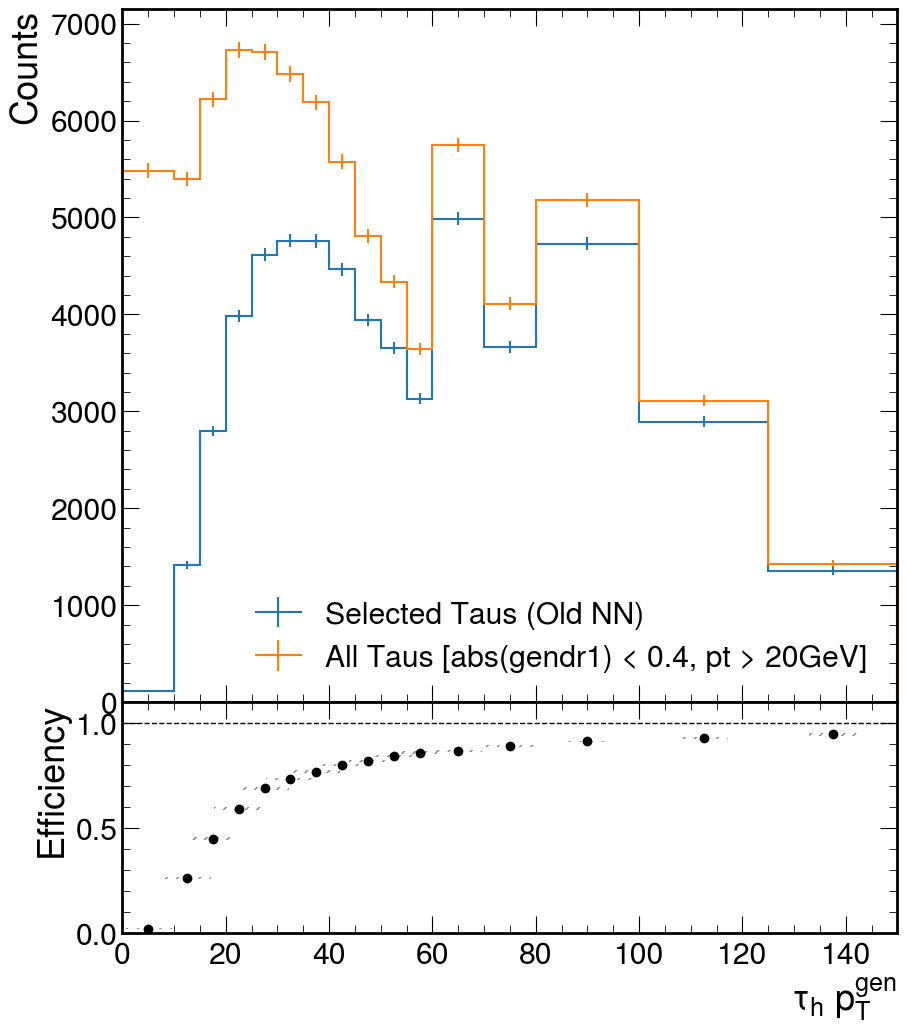

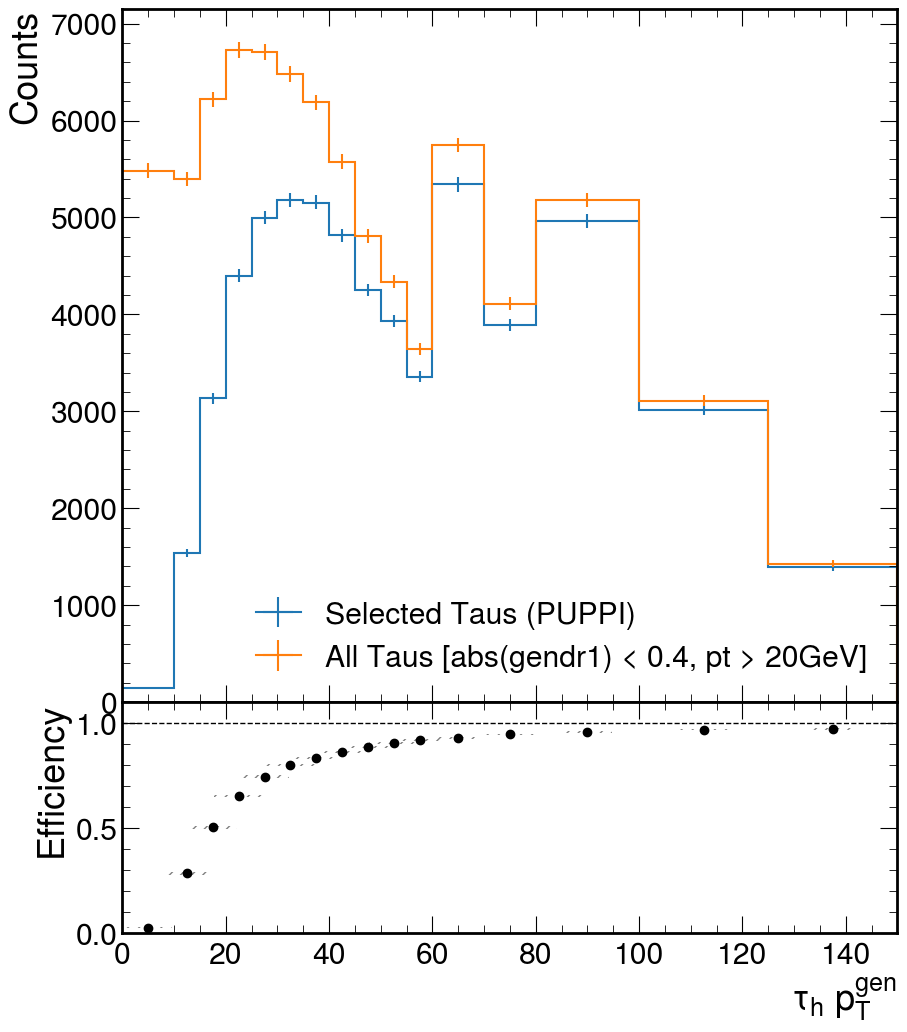

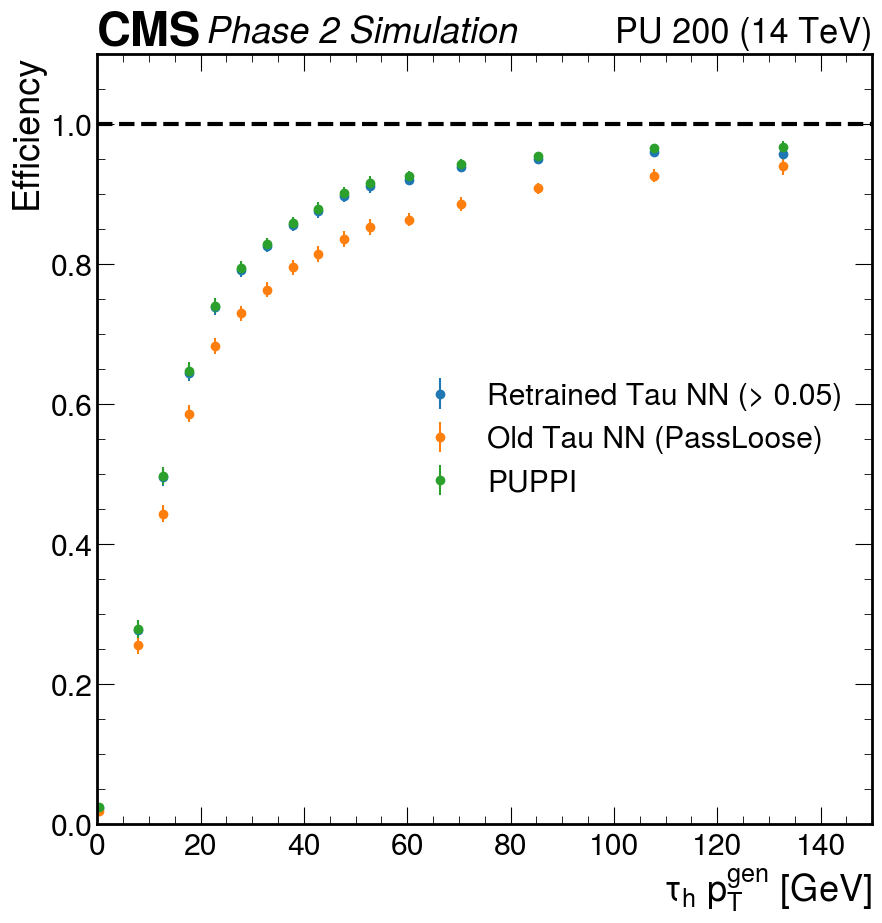

In [48]:
plot_pt_eff_puppi('../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5', "../ntuples/Jan_25_2023/test_sig_v12_emseed.root", cut_point = 0.05)

1545/1545 [==============================] - 1s 704us/step


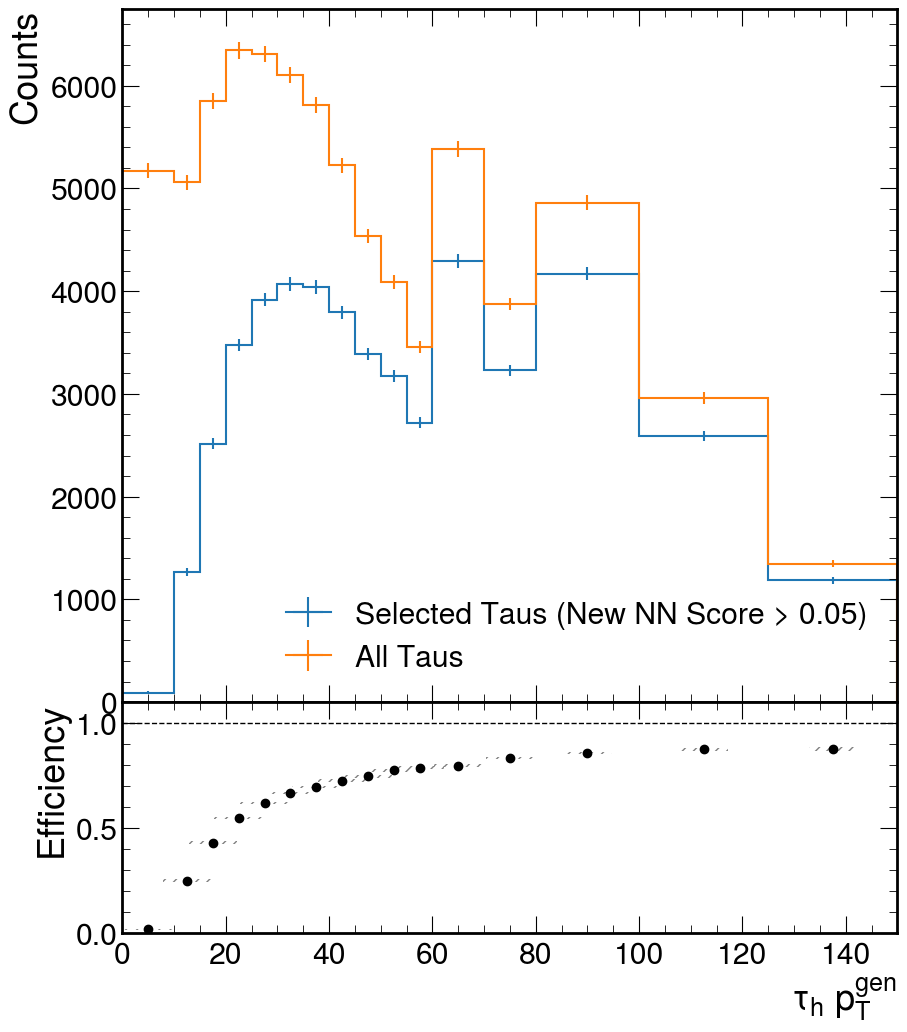

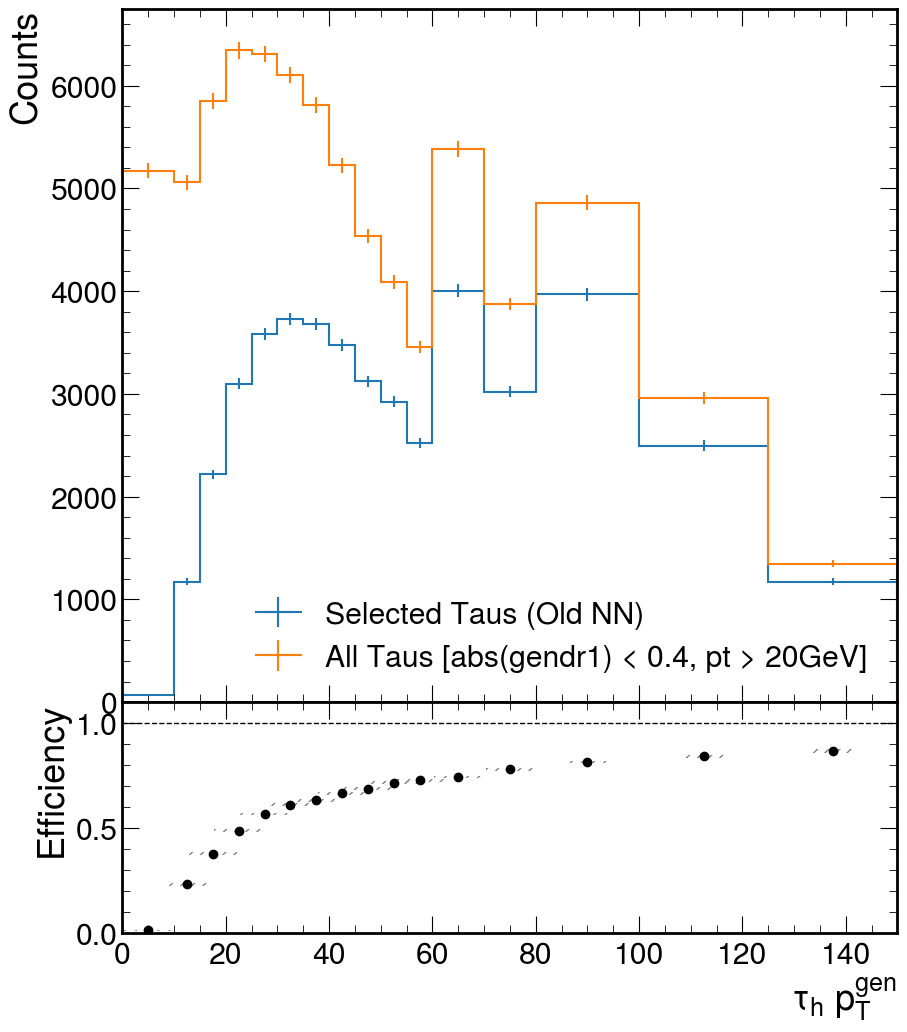

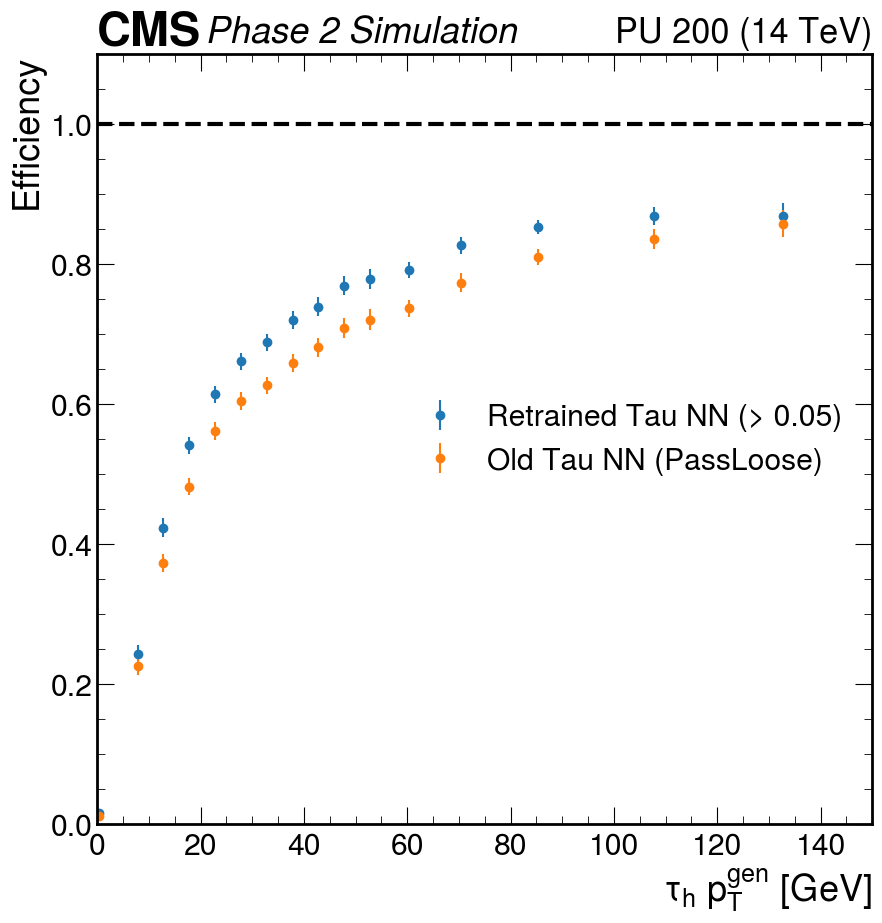

In [44]:
plot_pt_eff('../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5', "../ntuples/Jan_25_2023/test_sig_v11.root", cut_point = 0.05)

1545/1545 [==============================] - 1s 710us/step


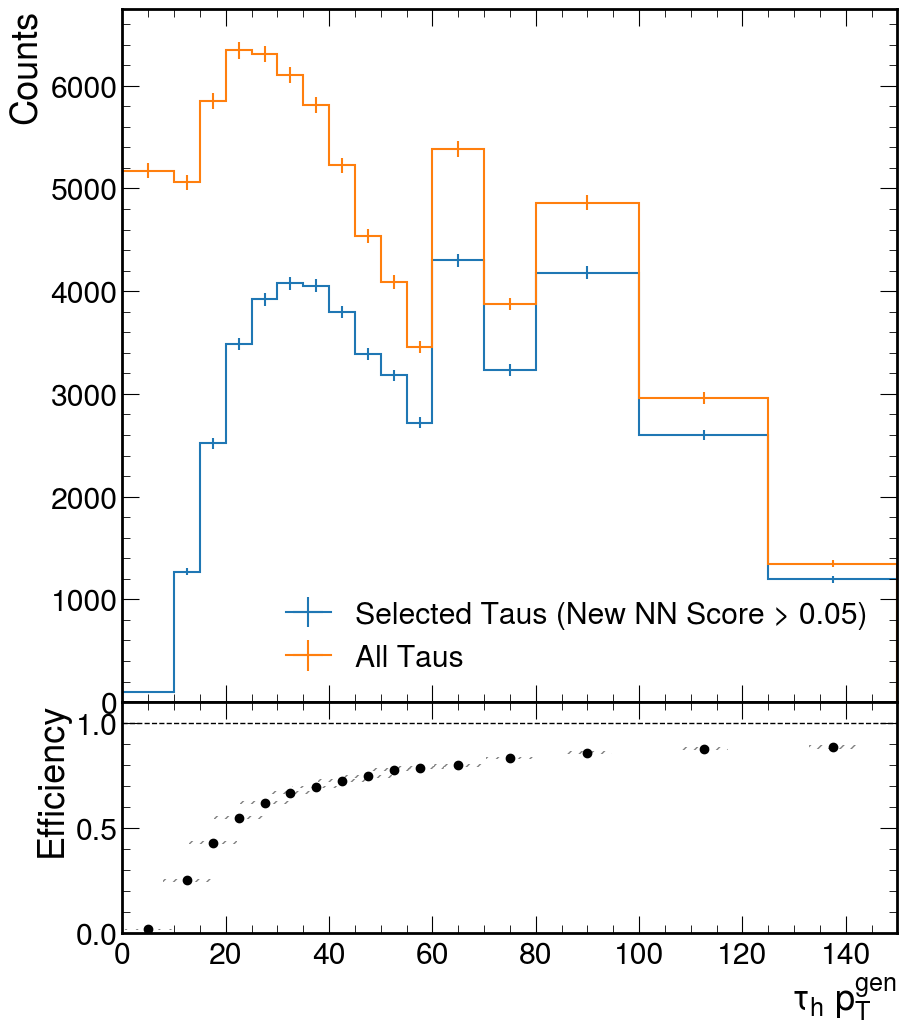

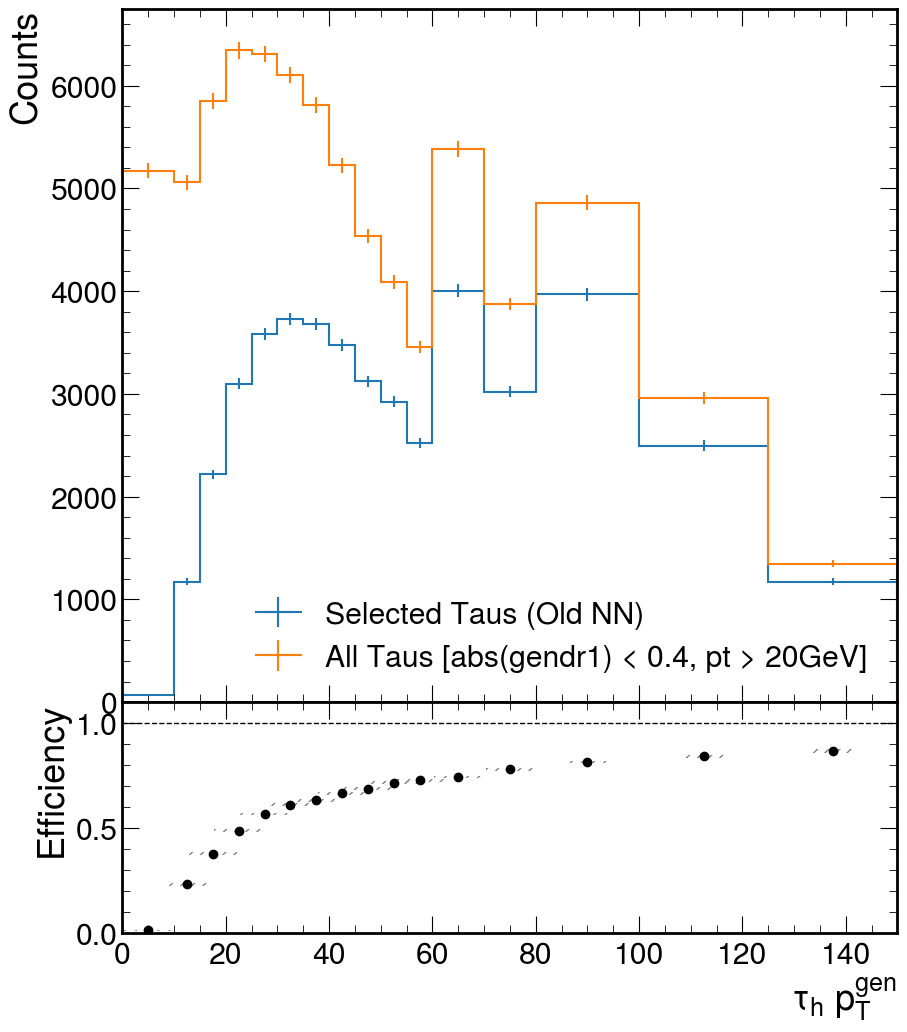

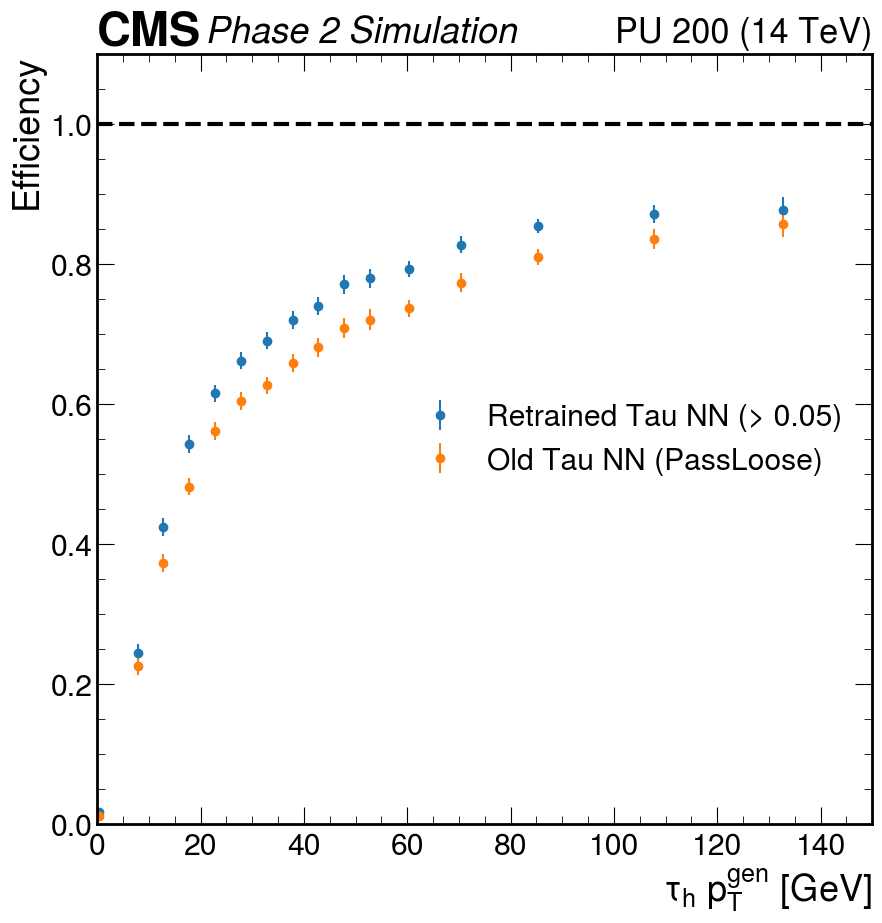

In [47]:
plot_pt_eff('../models/Feb_4_2023_JetMetTalk_v2_pTShape_TruthPtRatio.h5', "../ntuples/Jan_25_2023/test_sig_v11.root", cut_point = 0.05)

In [ ]:
plot_pt_eff('../models/Feb_4_2023_JetMetTalk_v2_pTShape_TruthPtRatio.h5', "../ntuples/Jan_25_2023/test_sig_v12_emseed.root", cut_point = 0.05)

1905/1905 [==============================] - 1s 722us/step


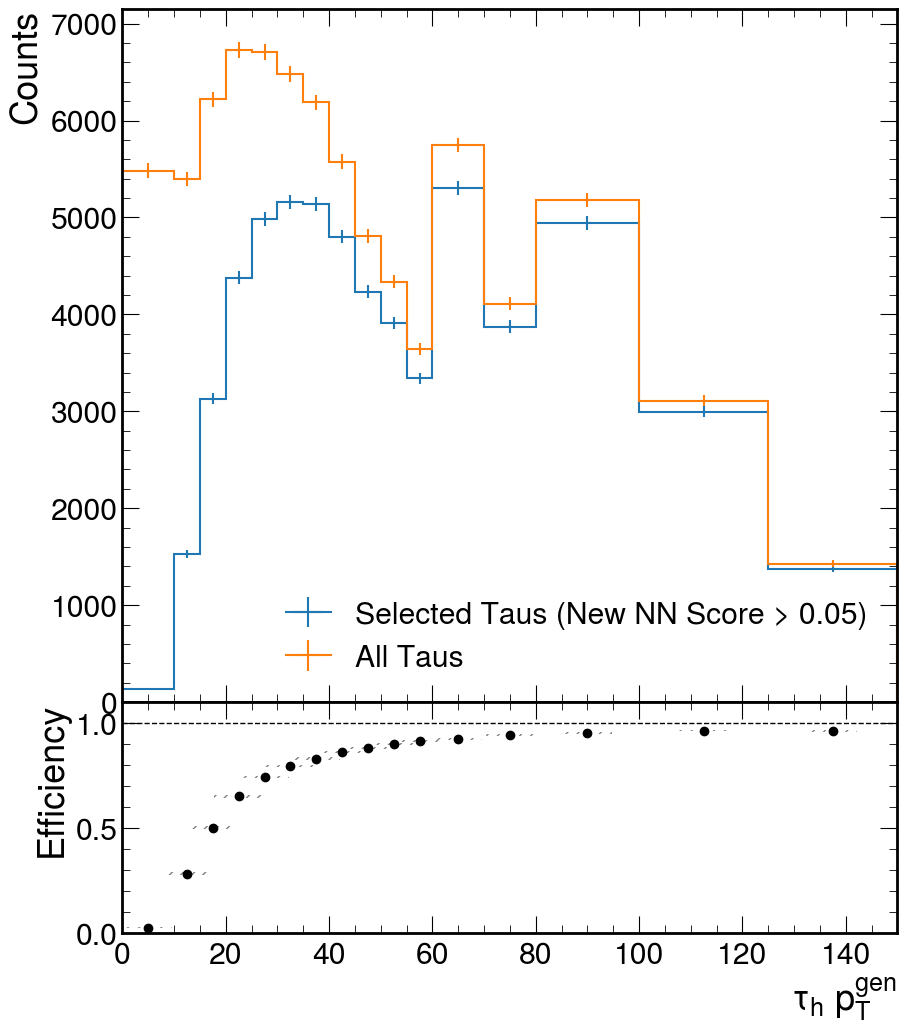

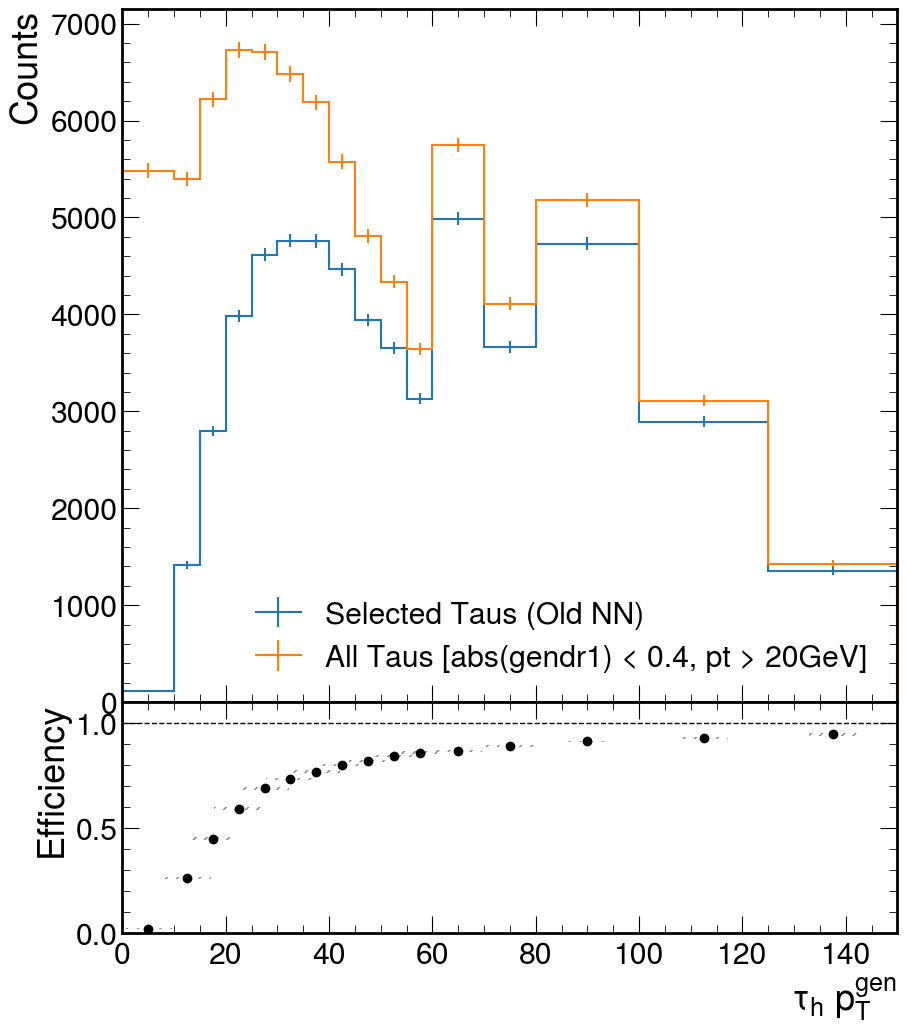

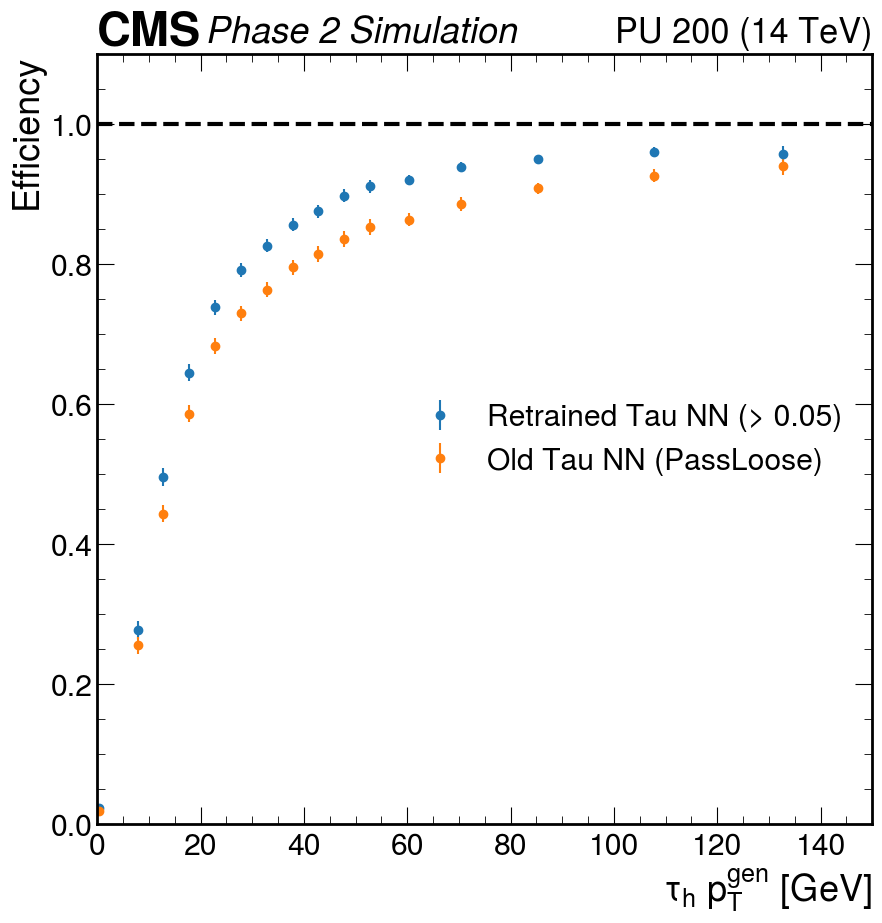

In [49]:
plot_pt_eff('../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5', "../ntuples/Jan_25_2023/test_sig_v12_emseed.root", cut_point = 0.05)

1905/1905 [==============================] - 1s 695us/step


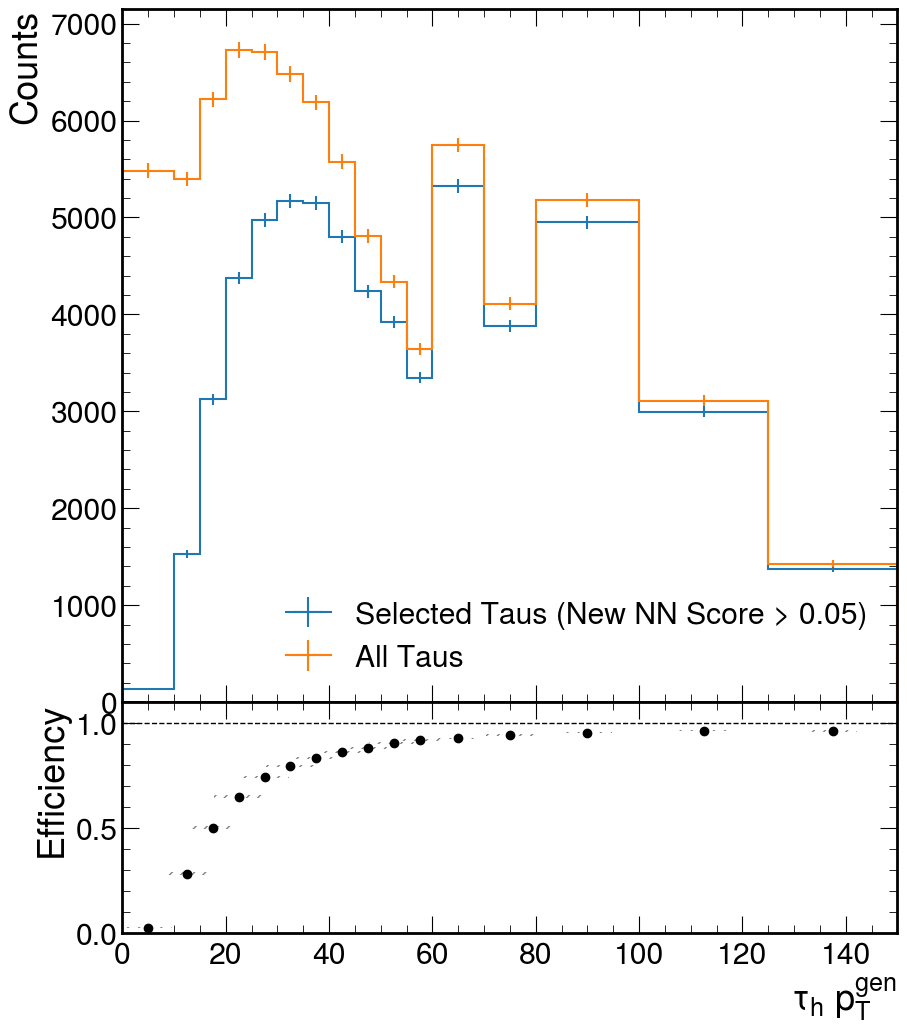

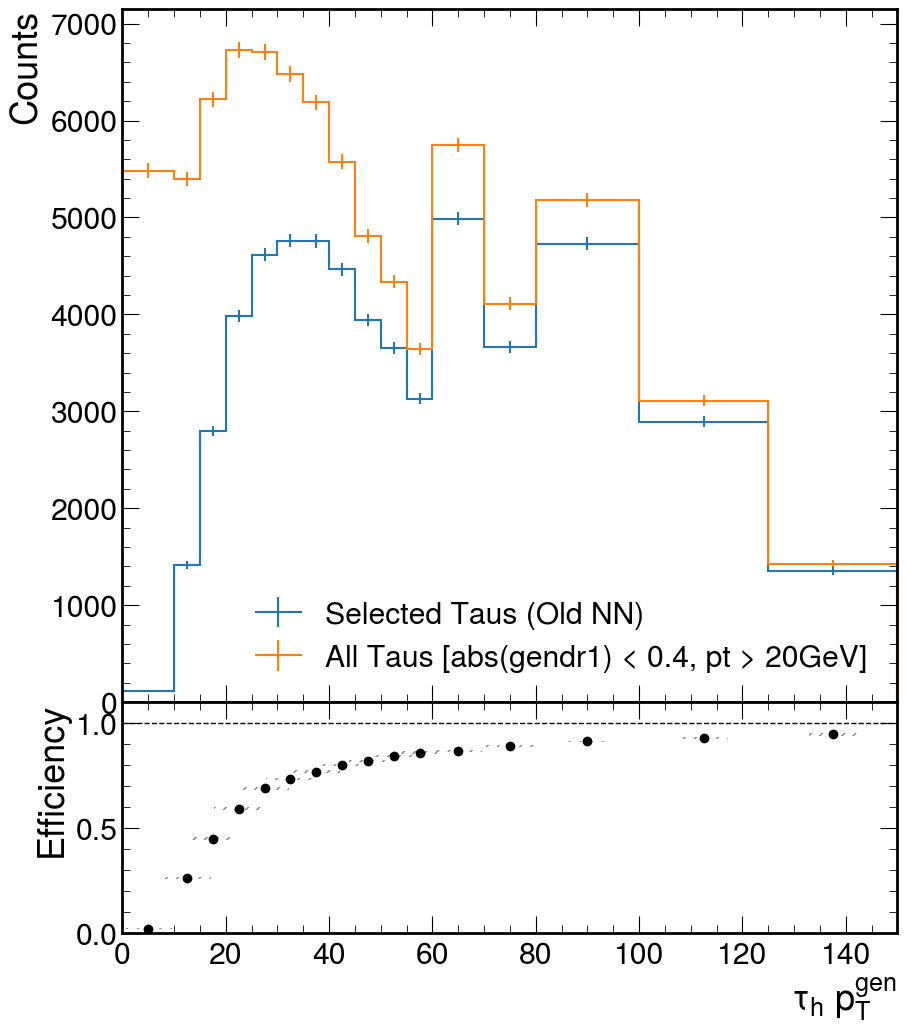

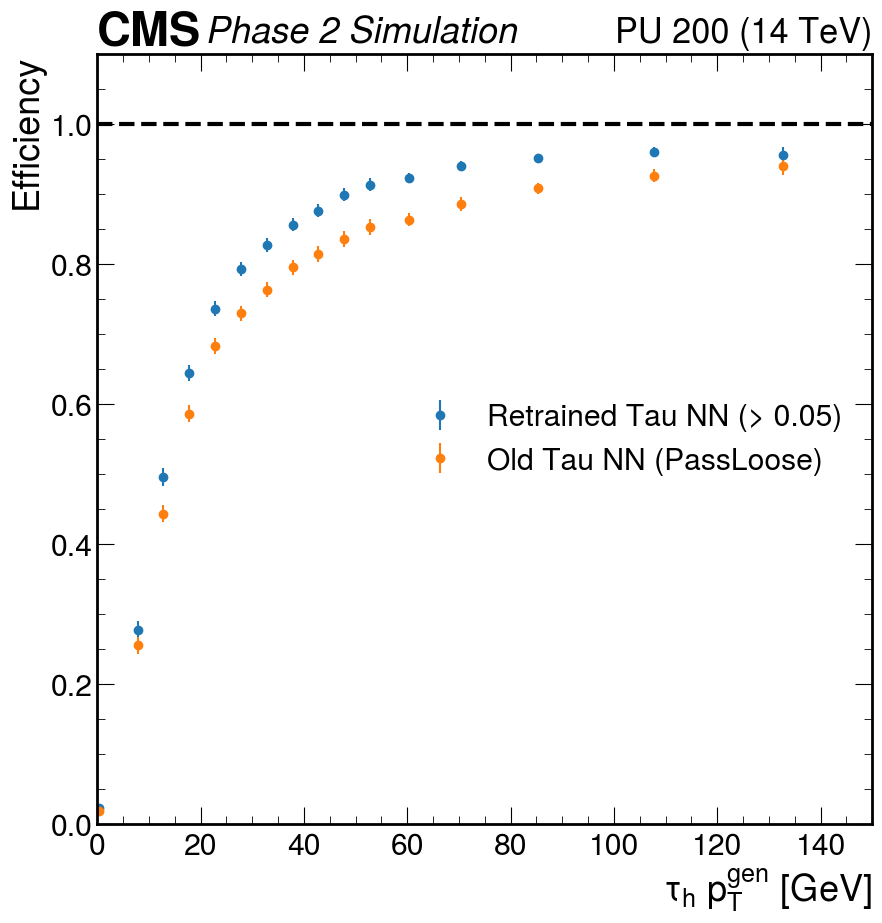

In [51]:
plot_pt_eff("../models/L1Tau_Jan_30_2023_EMSample_v2.h5", "../ntuples/Jan_25_2023/test_sig_v12_emseed.root", cut_point = 0.05)

1626/1626 [==============================] - 1s 687us/step


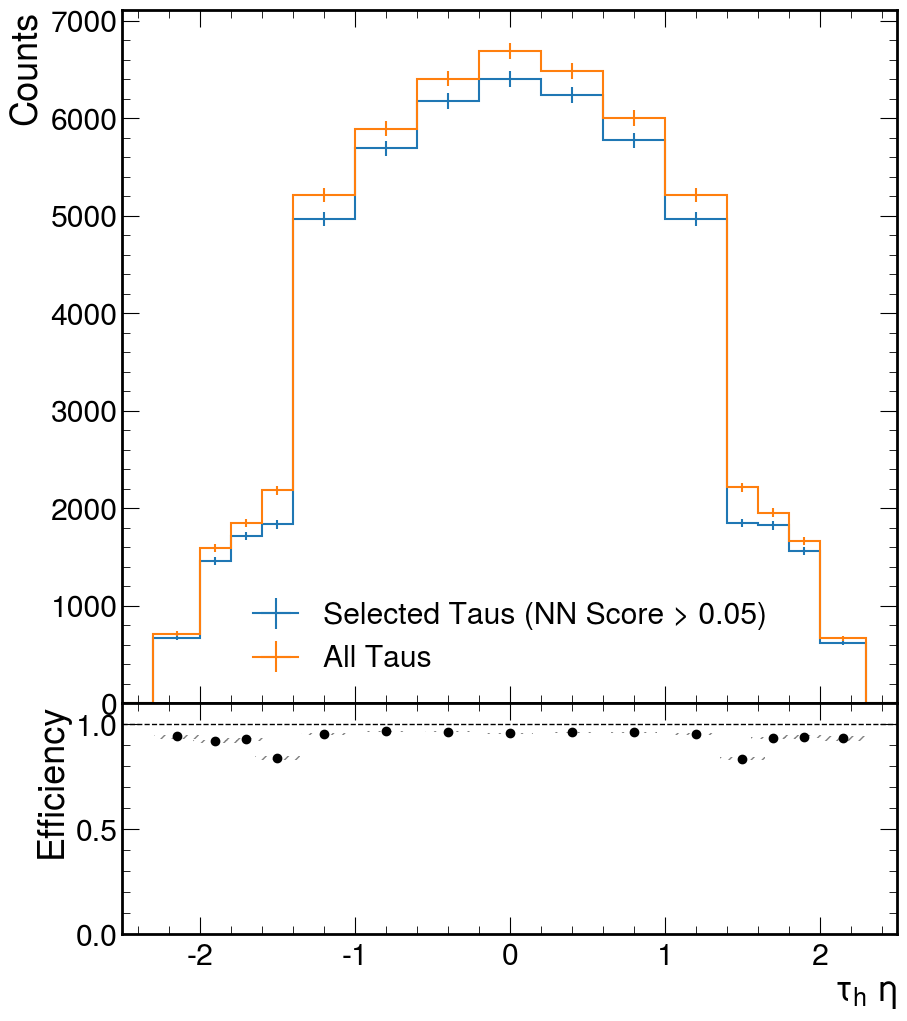

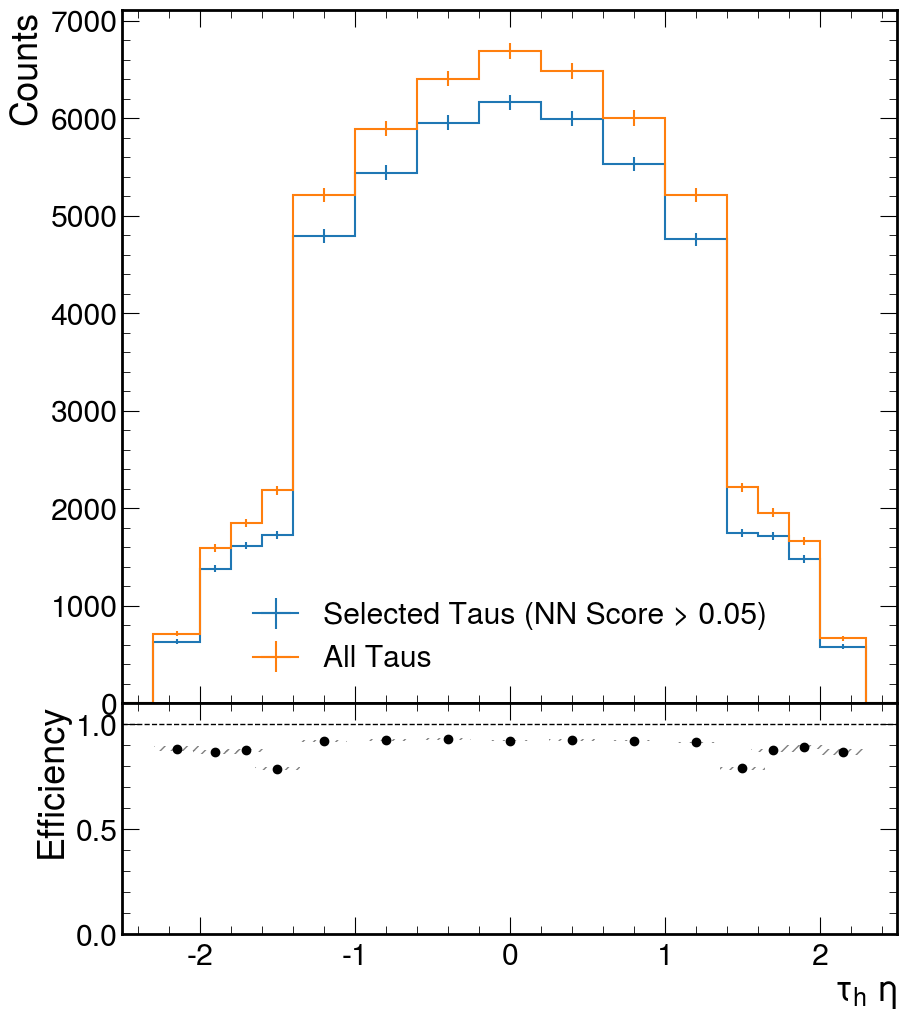

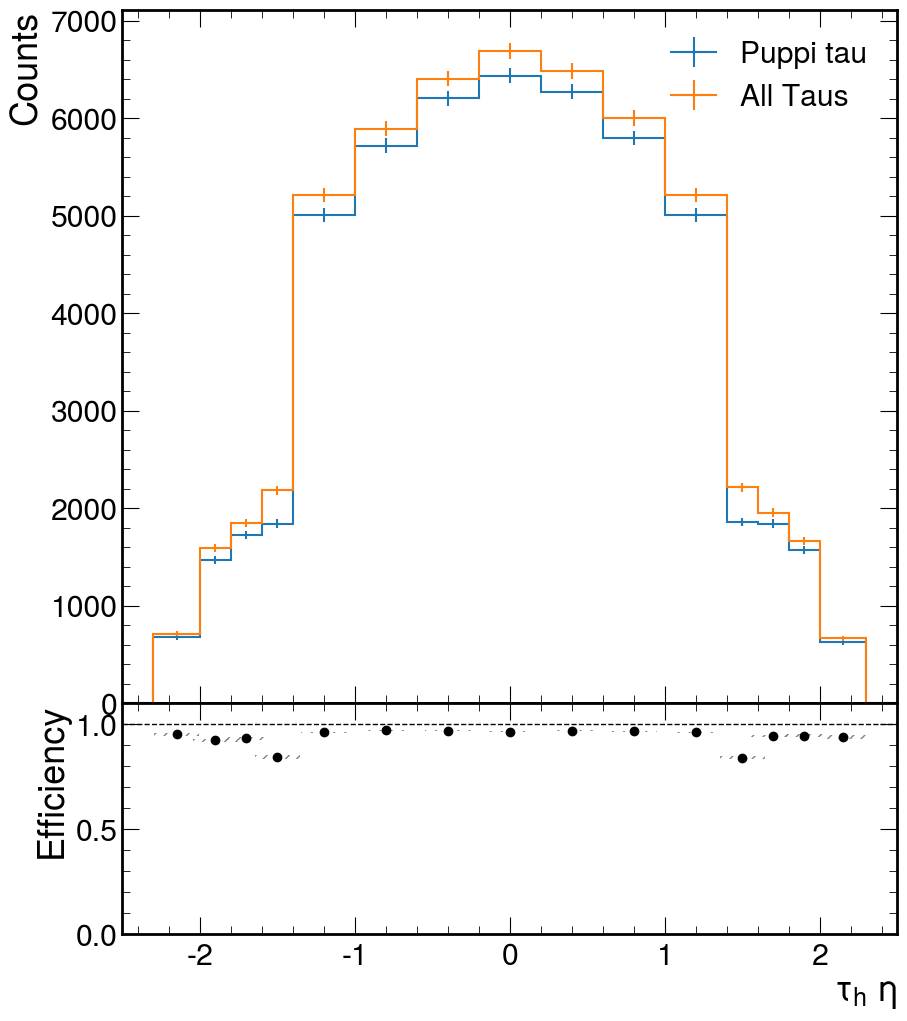

[-2.5470588235294116, -2.2970588235294116, -2.0470588235294116, -1.8470588235294119, -1.6470588235294117, -1.3470588235294116, -0.9470588235294117, -0.5470588235294117, -0.1470588235294117, 0.25294117647058834, 0.6529411764705884, 1.0529411764705883, 1.3529411764705883, 1.5529411764705885, 1.7529411764705882, 2.0029411764705882, 2.2529411764705882]
[0.0, 0.8703108072084111, 0.8594377709455246, 0.8672387555297701, 0.7792591142074803, 0.915451603799547, 0.9199928743450821, 0.9257528189737831, 0.9180486237962217, 0.9208210381113562, 0.9178860081590046, 0.9091145273011331, 0.7803017482369468, 0.8676528271934932, 0.8822886841883095, 0.8549774551629203, 0.0]


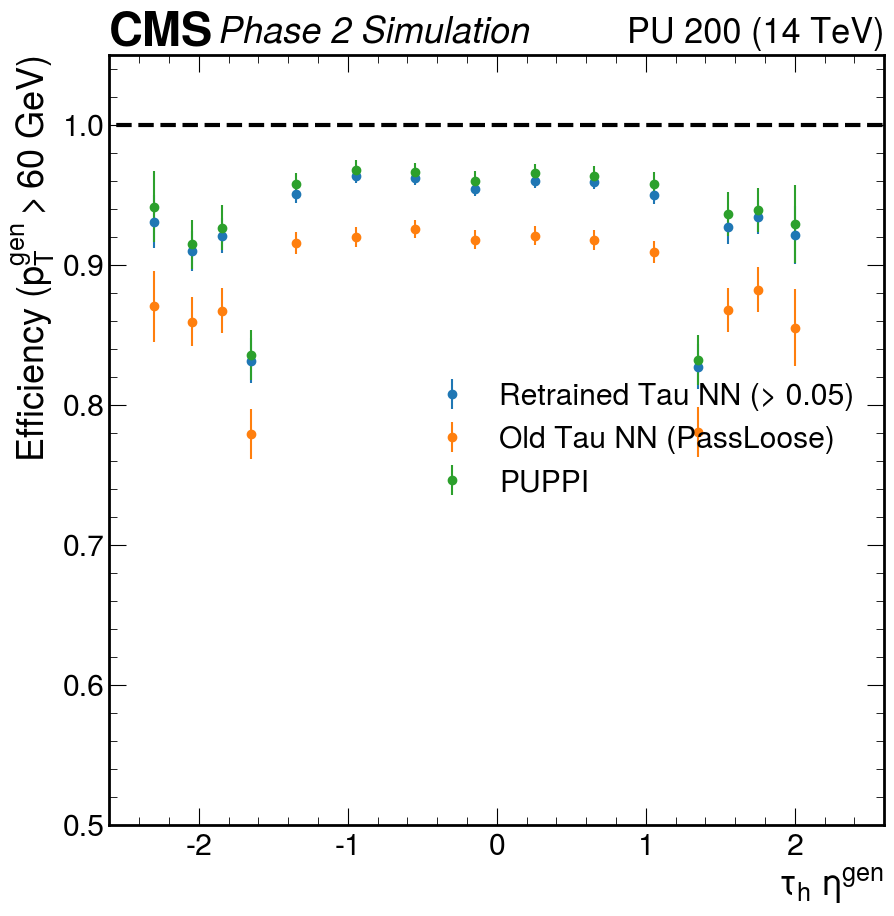

In [53]:
plot_eta_eff_puppi("../models/L1Tau_Jan_30_2023_EMSample_v2.h5", "../ntuples/Jan_25_2023/test_sig_v12_emseed.root", cut_point = 0.05)

# Efficiency w.r.t $\eta$ (testing set)

In [37]:
def plot_eta_eff(ModelName, DataPath, treename = 'ntuplePupSingle', cut_point = 0.05, test_indx=0):
    
    sig = uproot4.open(DataPath)
    reco_tau_pt = sig[treename]['tree']['pt'].array()[test_indx:]
    truth_tau_eta = sig[treename]['tree']['geneta1'].array()[test_indx:]
    reco_tau_eta = sig[treename]['tree']['eta'].array()[test_indx:]

    #Load model and select out the tau
    model = load_model(ModelName)

    #Get all the inputs
    sig_input = sig[treename]['tree']['m_inputs'].array()[test_indx:]

    pt_sig = sig[treename]['tree']['genpt1'].array()[test_indx:]
    deltaR_sig = sig[treename]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[treename]['tree']['geneta1'].array()[test_indx:]

    selection_deno = (pt_sig > 60.) & (abs(eta_sig) < 2.1) #"genpt1 > 60. && abs(geneta1) < 2.1"
    selection_num =  selection_deno & (abs(deltaR_sig) < 0.4) & (reco_tau_pt > 1.)
    #abs(gendr1) < 0.4 && abs(geneta1) < 2.1  && genpt1 > 60. && pt > 1"

    #Selected out the tau pt with the basic cuts first
    truth_tau_eta_select = truth_tau_eta[selection_num]
    reco_tau_eta_select = reco_tau_eta[selection_num]
    reco_tau_pt_select = reco_tau_pt[selection_num]
    
    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model.predict(np.nan_to_num(X_sig))
    
    nn_cut = y_sig.flatten() > cut_point
    
    tau_eta_nn = np.asarray(truth_tau_eta_select)[nn_cut]

    #Old nn
    old_tau_select = np.asarray(sig[treename]['tree']['passLoose'].array()[test_indx:][selection_num])
    tau_eta_old_nn = truth_tau_eta_select[old_tau_select == 1]

    #Fill two plots and divide the two.
    eta_egdes = [-2.5,-2.3,-2.0,-1.8,-1.6,-1.4,-1.0,-0.6,-0.2,0.2,0.6,1.0,1.4,1.6,1.8,2.0,2.3,2.5]
    eta_axis = hist.axis.Variable(eta_egdes, name = r"$\tau_h$ $\eta$")

    hist_all_tau = Hist(eta_axis)
    hist_selected_tau = Hist(eta_axis)
    hist_selected_old_tau = Hist(eta_axis)

    hist_all_tau.fill(truth_tau_eta[selection_deno])
    hist_selected_tau.fill(tau_eta_nn)
    hist_selected_old_tau.fill(tau_eta_old_nn)
    
    fig = plt.figure(figsize=(10, 12))
    main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (NN Score > 0.05)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (NN Score > 0.05)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = eff_new_nn_artists.bar.datavalues

    eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_err = eff_old_nn_artists.bar.datavalues
    
    print(eff_old_nn_x)
    print(eff_old_nn_y)

    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN (> 0.05)')
    plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN (PassLoose)')

    plt.hlines(1, -3, 3, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.5,1.05])
    plt.xlim([-2.6,2.6])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $\eta^{gen}$")
    plt.ylabel(r"Efficiency ($p_T^{gen} > 60$ GeV)")
    plt.legend(loc = 'center right')
    plt.show()

1492/1492 [==============================] - 1s 700us/step


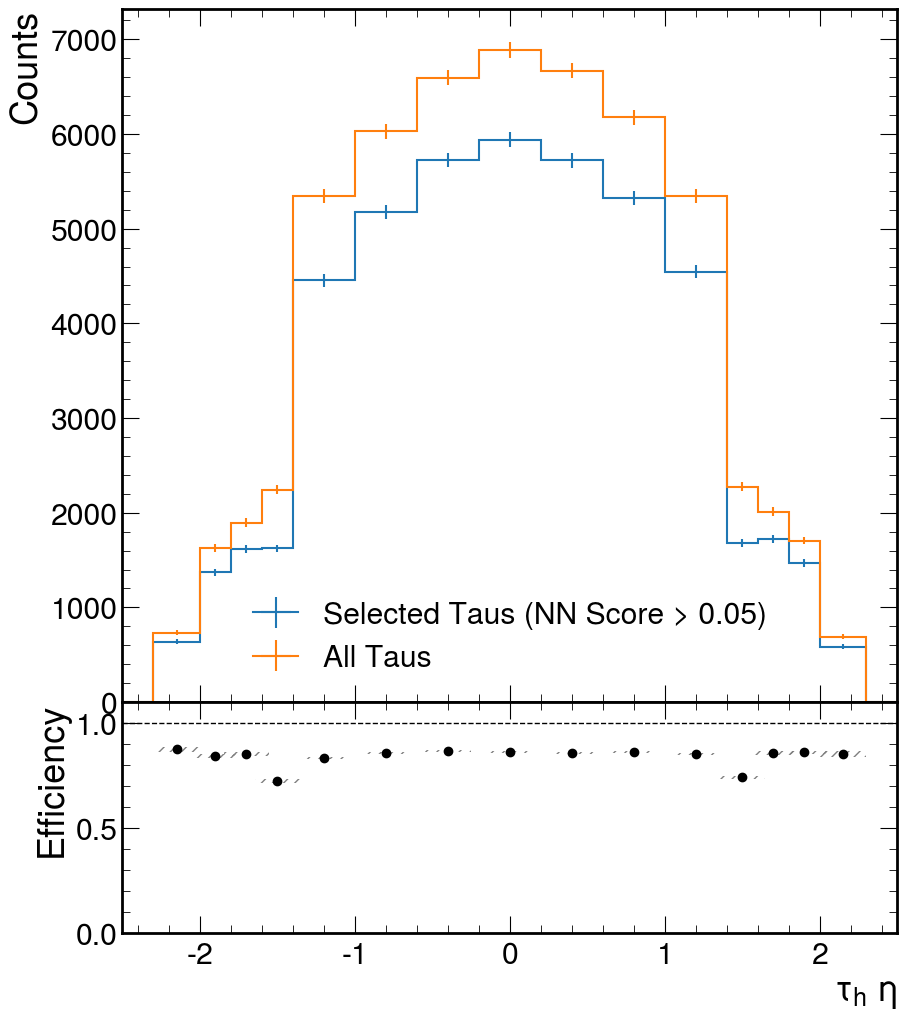

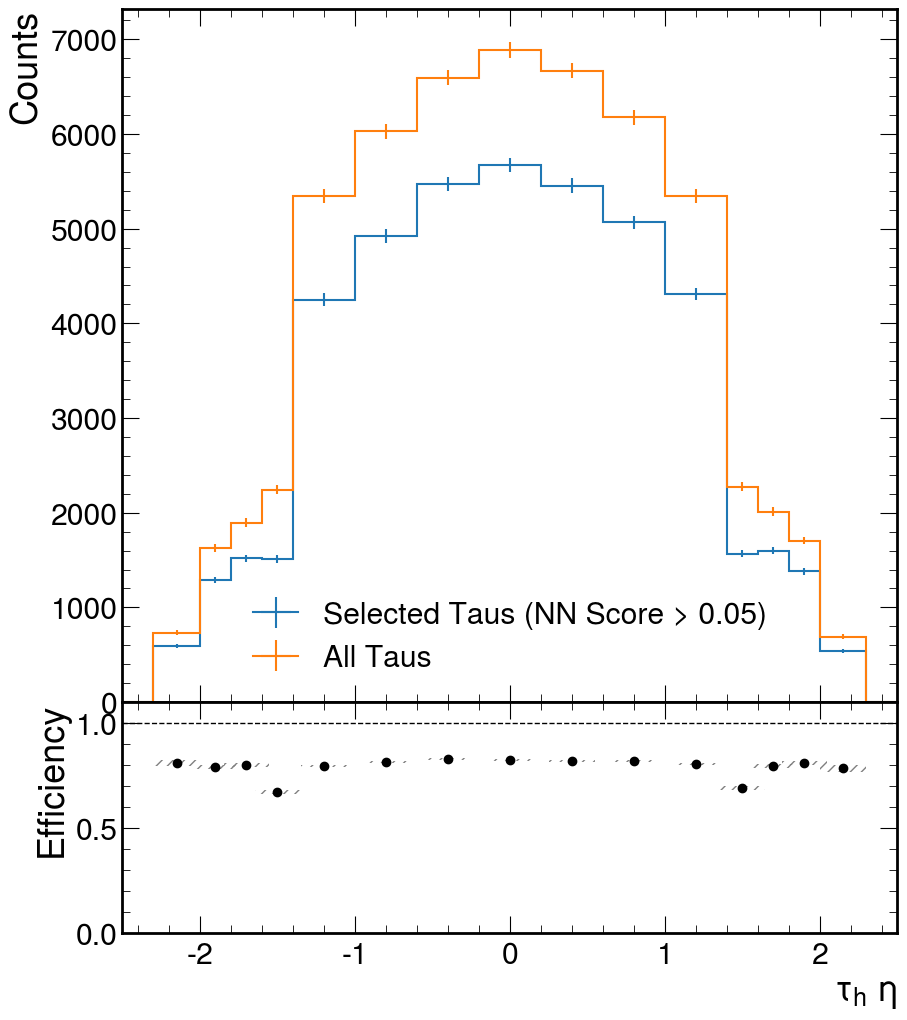

[-2.5470588235294116, -2.2970588235294116, -2.0470588235294116, -1.8470588235294119, -1.6470588235294117, -1.3470588235294116, -0.9470588235294117, -0.5470588235294117, -0.1470588235294117, 0.25294117647058834, 0.6529411764705884, 1.0529411764705883, 1.3529411764705883, 1.5529411764705885, 1.7529411764705882, 2.0029411764705882, 2.2529411764705882]
[0.0, 0.7942146418531552, 0.7817077242719368, 0.790496162052104, 0.6625530066273692, 0.7888281922258578, 0.8115379901951758, 0.825144219198847, 0.8191345087480943, 0.812991885231365, 0.815089196492221, 0.8012976912918637, 0.6805792659835187, 0.7857287163835687, 0.8001070964221202, 0.7695570870895883, 0.0]


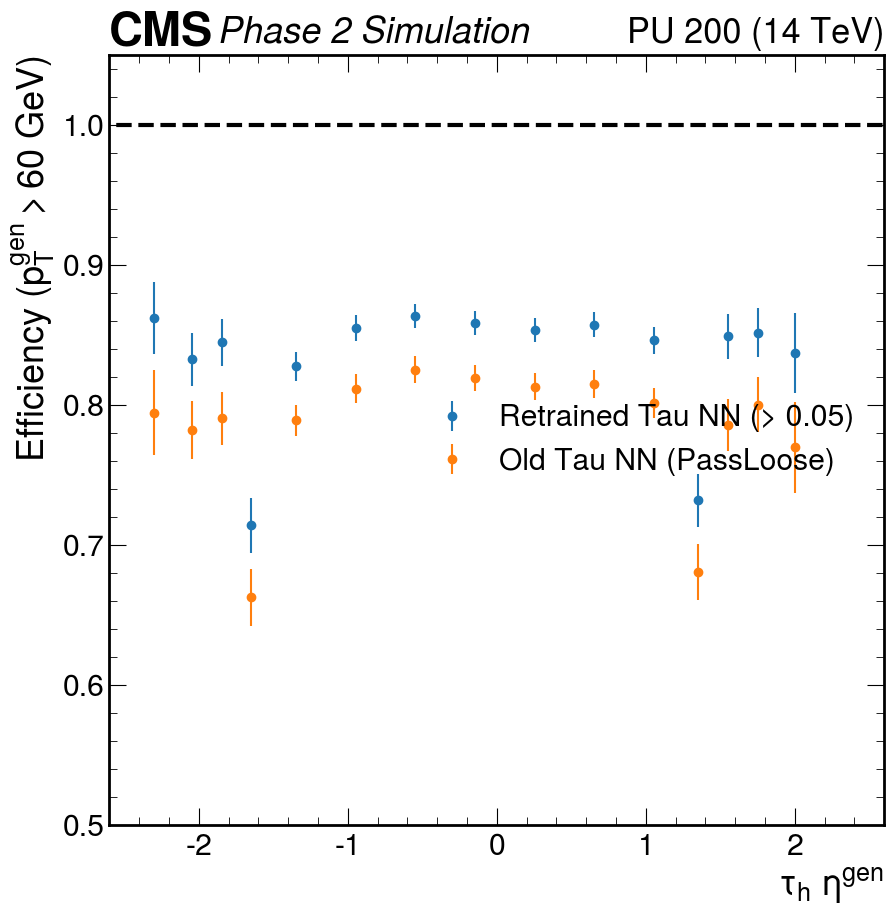

In [46]:
plot_eta_eff('../models/Feb_4_2023_JetMetTalk_v2_pTShape_TruthPtRatio.h5', "../ntuples/Jan_25_2023/test_sig_v11.root", cut_point = 0.05)

In [41]:
def plot_eta_eff_puppi(ModelName, DataPath, treename = 'ntuplePupSingle', cut_point = 0.05, test_indx=0):
    
    sig = uproot4.open(DataPath)
    reco_tau_pt = sig[treename]['tree']['pt'].array()[test_indx:]
    truth_tau_eta = sig[treename]['tree']['geneta1'].array()[test_indx:]
    reco_tau_eta = sig[treename]['tree']['eta'].array()[test_indx:]

    #Load model and select out the tau
    model = load_model(ModelName)

    #Get all the inputs
    sig_input = sig[treename]['tree']['m_inputs'].array()[test_indx:]

    pt_sig = sig[treename]['tree']['genpt1'].array()[test_indx:]
    deltaR_sig = sig[treename]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[treename]['tree']['geneta1'].array()[test_indx:]

    selection_deno = (pt_sig > 60.) & (abs(eta_sig) < 2.1) #"genpt1 > 60. && abs(geneta1) < 2.1"
    selection_num =  selection_deno & (abs(deltaR_sig) < 0.4) & (reco_tau_pt > 1.)
    #abs(gendr1) < 0.4 && abs(geneta1) < 2.1  && genpt1 > 60. && pt > 1"

    #Selected out the tau pt with the basic cuts first
    truth_tau_eta_select = truth_tau_eta[selection_num]
    reco_tau_eta_select = reco_tau_eta[selection_num]
    reco_tau_pt_select = reco_tau_pt[selection_num]
    
    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model.predict(np.nan_to_num(X_sig))
    
    nn_cut = y_sig.flatten() > cut_point
    
    tau_eta_nn = np.asarray(truth_tau_eta_select)[nn_cut]

    #Old nn
    old_tau_select = np.asarray(sig[treename]['tree']['passLoose'].array()[test_indx:][selection_num])
    tau_eta_old_nn = truth_tau_eta_select[old_tau_select == 1]

    #Fill two plots and divide the two.
    eta_egdes = [-2.5,-2.3,-2.0,-1.8,-1.6,-1.4,-1.0,-0.6,-0.2,0.2,0.6,1.0,1.4,1.6,1.8,2.0,2.3,2.5]
    eta_axis = hist.axis.Variable(eta_egdes, name = r"$\tau_h$ $\eta$")

    hist_all_tau = Hist(eta_axis)
    hist_puppi_tau = Hist(eta_axis)
    hist_selected_tau = Hist(eta_axis)
    hist_selected_old_tau = Hist(eta_axis)

    hist_all_tau.fill(truth_tau_eta[selection_deno])
    hist_puppi_tau.fill(truth_tau_eta_select)
    hist_selected_tau.fill(tau_eta_nn)
    hist_selected_old_tau.fill(tau_eta_old_nn)
    
    fig = plt.figure(figsize=(10, 12))
    main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (NN Score > 0.05)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (NN Score > 0.05)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_puppi_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Puppi tau",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = eff_new_nn_artists.bar.datavalues

    eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_err = eff_old_nn_artists.bar.datavalues
    
    print(eff_old_nn_x)
    print(eff_old_nn_y)
    
    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err = eff_puppi_artists.bar.datavalues

    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN (> 0.05)')
    plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN (PassLoose)')
    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_old_nn_err, fmt='o', label = 'PUPPI')

    plt.hlines(1, -3, 3, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.5,1.05])
    plt.xlim([-2.6,2.6])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $\eta^{gen}$")
    plt.ylabel(r"Efficiency ($p_T^{gen} > 60$ GeV)")
    plt.legend(loc = 'center right')
    plt.show()

1492/1492 [==============================] - 1s 728us/step


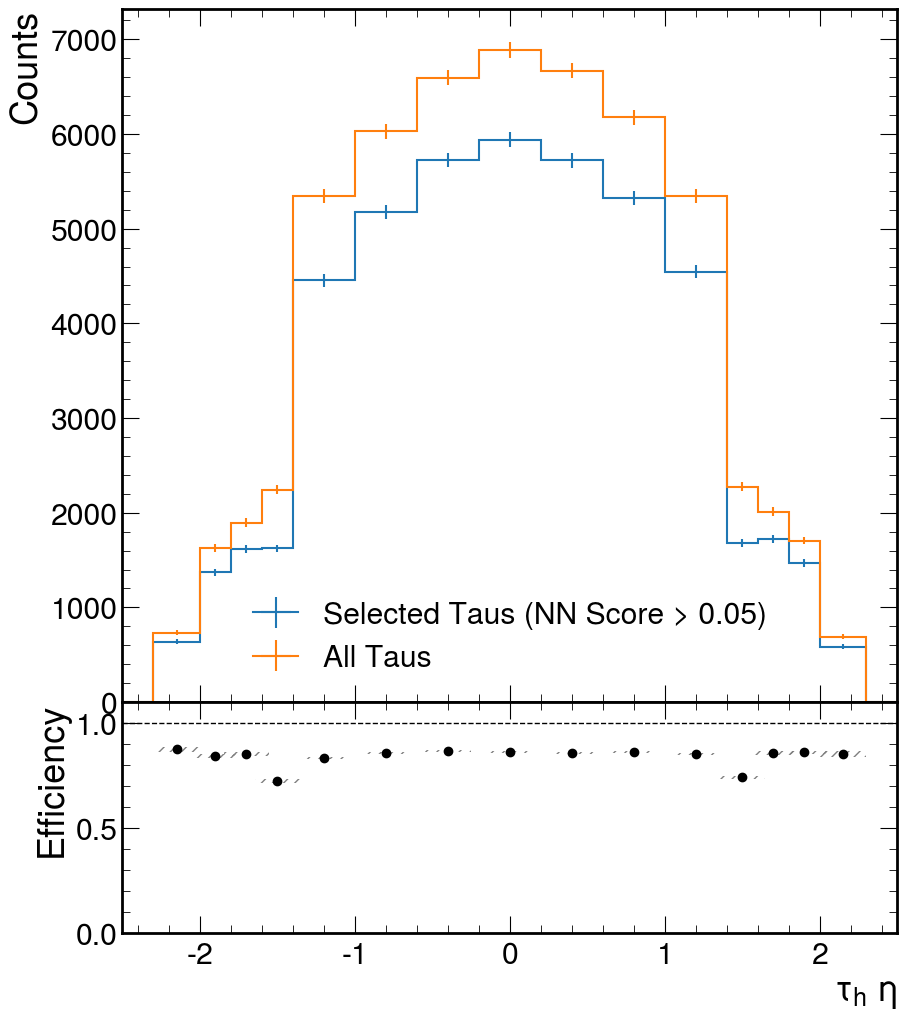

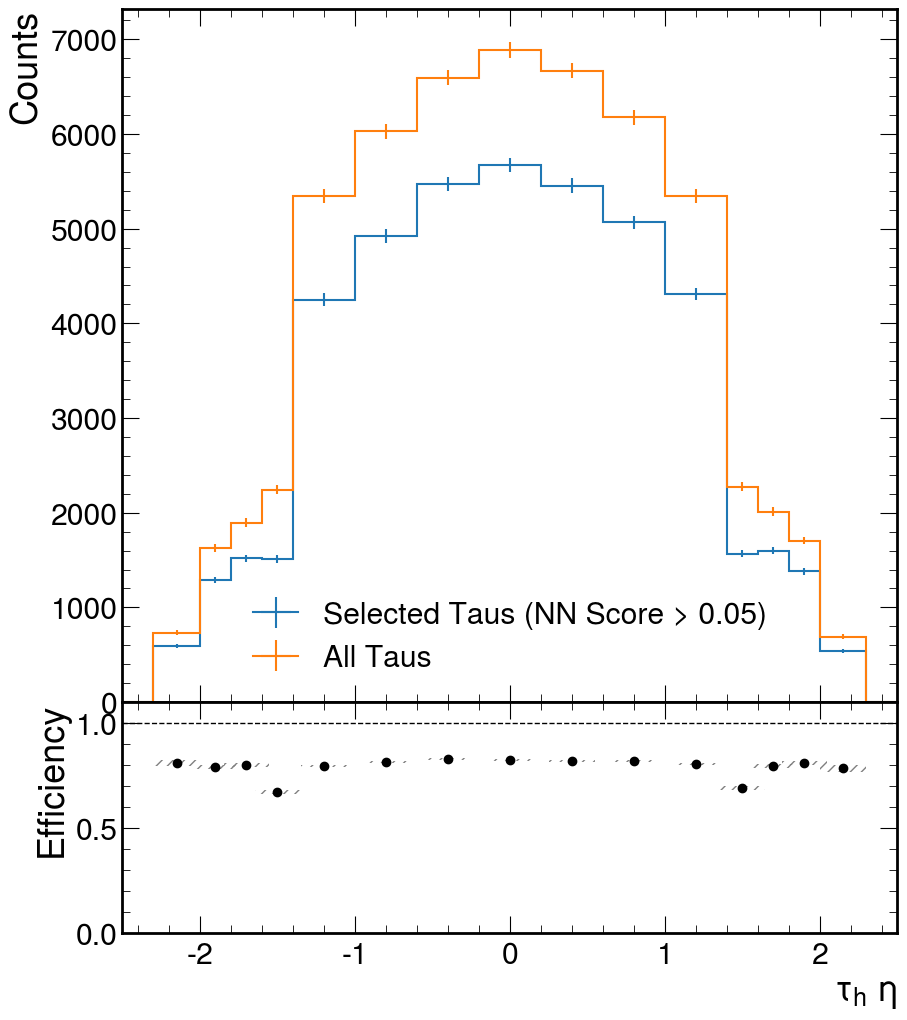

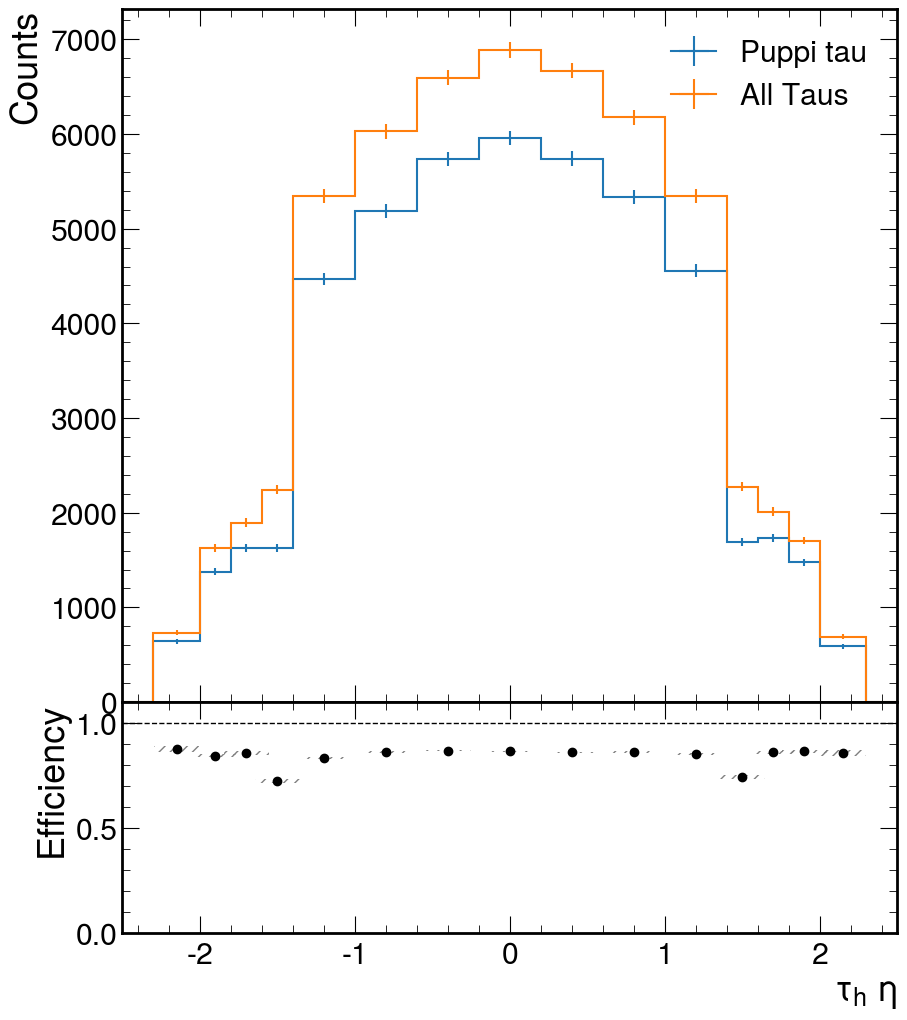

[-2.5470588235294116, -2.2970588235294116, -2.0470588235294116, -1.8470588235294119, -1.6470588235294117, -1.3470588235294116, -0.9470588235294117, -0.5470588235294117, -0.1470588235294117, 0.25294117647058834, 0.6529411764705884, 1.0529411764705883, 1.3529411764705883, 1.5529411764705885, 1.7529411764705882, 2.0029411764705882, 2.2529411764705882]
[0.0, 0.7942146418531552, 0.7817077242719368, 0.790496162052104, 0.6625530066273692, 0.7888281922258578, 0.8115379901951758, 0.825144219198847, 0.8191345087480943, 0.812991885231365, 0.815089196492221, 0.8012976912918637, 0.6805792659835187, 0.7857287163835687, 0.8001070964221202, 0.7695570870895883, 0.0]


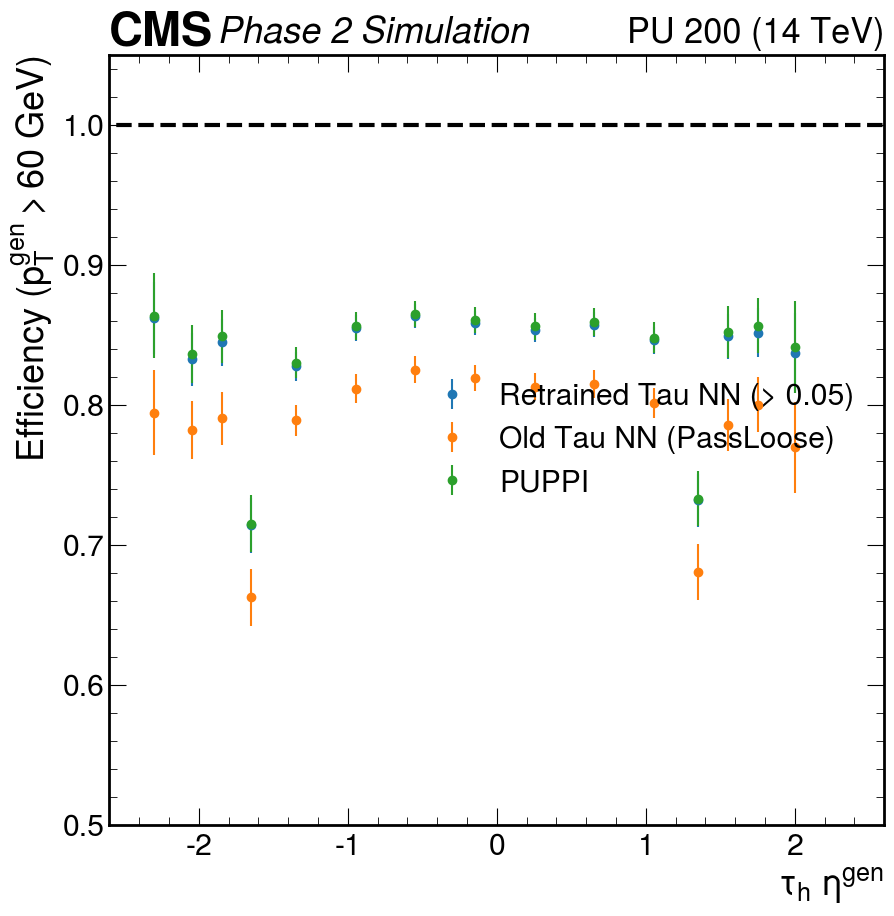

In [45]:
plot_eta_eff_puppi('../models/Feb_4_2023_JetMetTalk_v2_pTShape_TruthPtRatio.h5', "../ntuples/Jan_25_2023/test_sig_v11.root", cut_point = 0.05)

1626/1626 [==============================] - 1s 721us/step


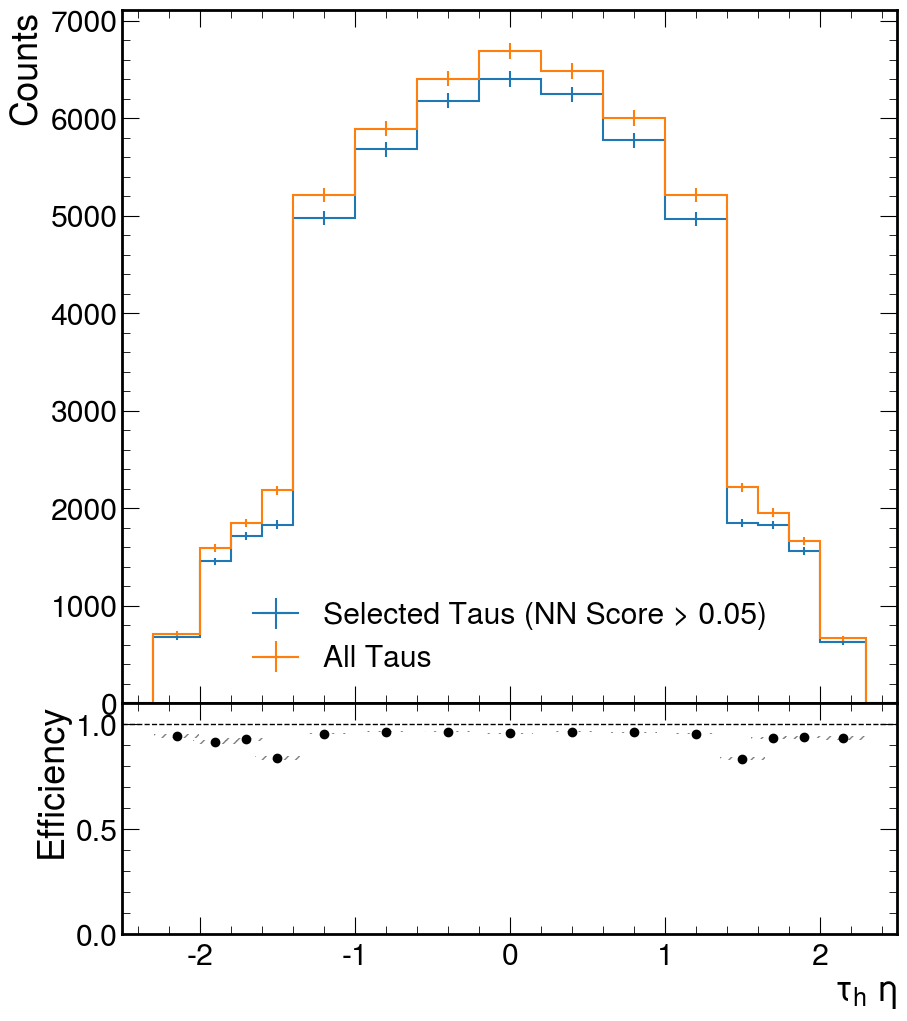

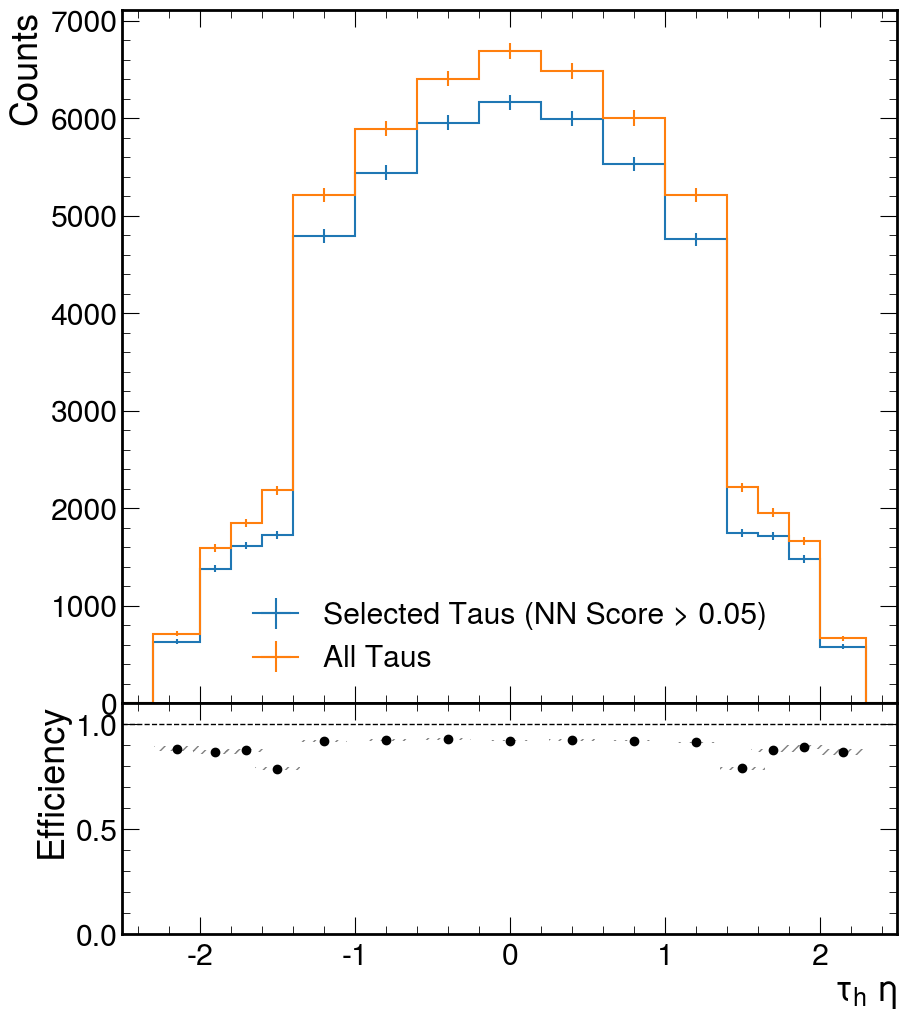

[-2.5470588235294116, -2.2970588235294116, -2.0470588235294116, -1.8470588235294119, -1.6470588235294117, -1.3470588235294116, -0.9470588235294117, -0.5470588235294117, -0.1470588235294117, 0.25294117647058834, 0.6529411764705884, 1.0529411764705883, 1.3529411764705883, 1.5529411764705885, 1.7529411764705882, 2.0029411764705882, 2.2529411764705882]
[0.0, 0.8703108072084111, 0.8594377709455246, 0.8672387555297701, 0.7792591142074803, 0.915451603799547, 0.9199928743450821, 0.9257528189737831, 0.9180486237962217, 0.9208210381113562, 0.9178860081590046, 0.9091145273011331, 0.7803017482369468, 0.8676528271934932, 0.8822886841883095, 0.8549774551629203, 0.0]


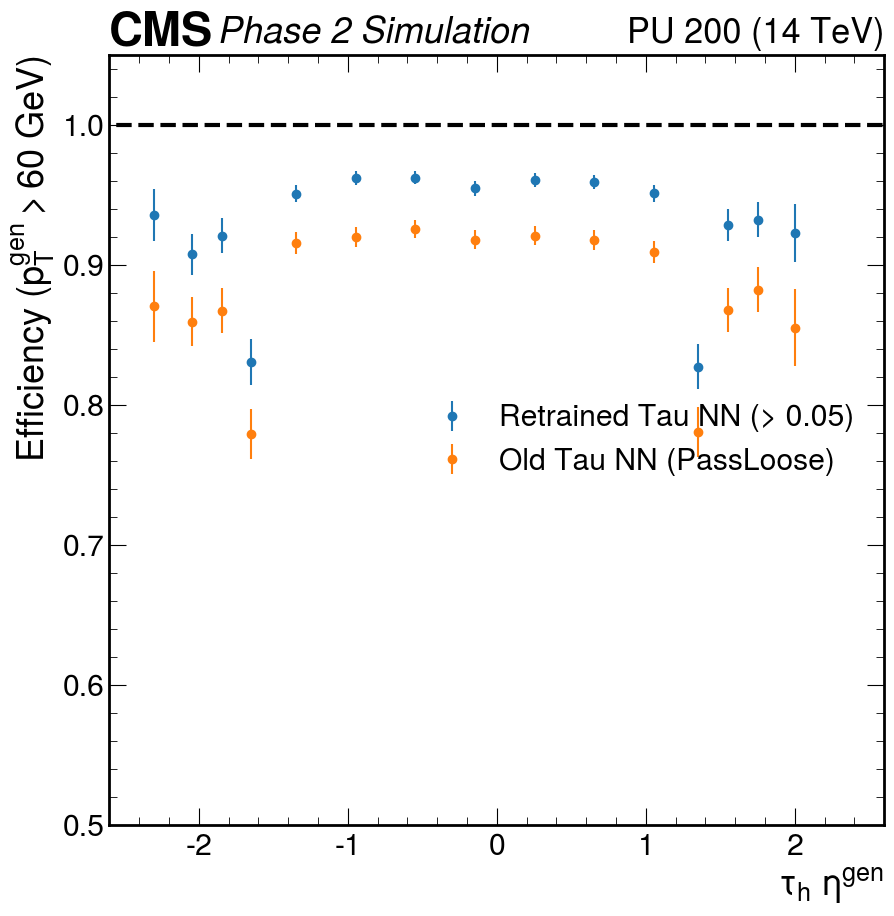

In [50]:
plot_eta_eff('../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5', "../ntuples/Jan_25_2023/test_sig_v12_emseed.root", cut_point = 0.05)